In [3]:
import os
import nibabel as nib
import numpy as np

# 指定ground truth和预测值的根目录
gt_root = "/data2/mayupeng/HCP_25_dataset_ori"
pred_root = "/data2/mayupeng/predict"

# 指标名称
features = ["FIT_ICVF", "FIT_ISOVF", "FIT_OD"]

# 人员编号列表
subject_ids = [
    "101107", "101309", "101410", "101915", "102008",
    "102109", "102311", "102513", "102614", "102715",
    "102816", "103010", "103111", "103212", "103414",
    "103515", "103818", "104012", "104416", "104820"
]

# 用于存储MSE值的字典
mse_values = []

# 计算每个指标的MSE值
for subject_id in subject_ids:
    # 加载mask
    mask_path = os.path.join(gt_root, subject_id, "nodif_brain_mask.nii.gz")
    mask = nib.load(mask_path).get_fdata(dtype=np.float32)

    for feature in features:
        gt_path = os.path.join(gt_root, subject_id, "NODDI", f"{feature}.nii.gz")
        pred_path = os.path.join(pred_root, subject_id, "NODDI", f"{feature}.nii.gz")
        
        # 加载ground truth和预测值的图像
        gt_img = nib.load(gt_path).get_fdata(dtype=np.float32)
        pred_img = nib.load(pred_path).get_fdata(dtype=np.float32)
        
        # 在mask为1的区域计算MAE
        mse = np.mean((np.abs(gt_img - pred_img))[mask == 1])
        mse_values.append({'subject_id': subject_id, 'feature': feature, 'mse': mse})

# 打印结果
for item in mse_values:
    print(f"Subject {item['subject_id']} Feature {item['feature']} MSE: {item['mse']}")


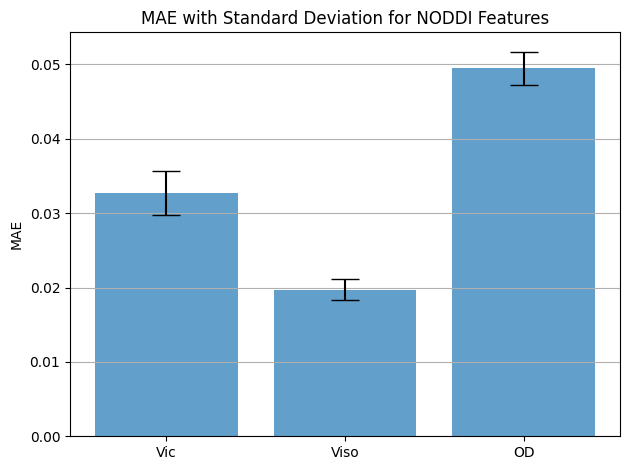

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
# 定义MSE值列表
icvf_mse = [
    0.031141212210059166, 0.035810381174087524, 0.030803237110376358, 0.02971494570374489, 
    0.04285619780421257, 0.034763023257255554, 0.03203163295984268, 0.030592055991292,
    0.03206135705113411, 0.036017950624227524, 0.030864674597978592, 0.03234025835990906,
    0.03308458998799324, 0.03374841436743736, 0.031190287321805954, 0.03267397731542587,
    0.028519824147224426, 0.03174656629562378, 0.03210161626338959, 0.0322333462536335
]
isovf_mse = [
    0.01928918994963169, 0.021773481741547585, 0.019490890204906464, 0.01787014678120613,
    0.021213464438915253, 0.021807696670293808, 0.01878509670495987, 0.018866194412112236,
    0.019682567566633224, 0.02283763326704502, 0.019281651824712753, 0.020395873114466667,
    0.020172961056232452, 0.020156875252723694, 0.01855805329978466, 0.018798435106873512,
    0.0166309904307127, 0.01945684663951397, 0.01966664381325245, 0.019745683297514915
]
od_mse = [
    0.0483243390917778, 0.0517427884042263, 0.04787474870681763, 0.0474475622177124,
    0.05609390512108803, 0.052549153566360474, 0.05007362365722656, 0.0473112016916275,
    0.04811853915452957, 0.05131059139966965, 0.047751013189554214, 0.04914331063628197,
    0.04904928430914879, 0.050525251775979996, 0.04959218576550484, 0.050143051892519,
    0.045158907771110535, 0.04996783658862114, 0.04787365719676018, 0.0489172488451004
]
icvf_mse = np.array(icvf_mse)
isovf_mse = np.array(isovf_mse)
od_mse = np.array(od_mse)
# 输出为三个列表的形式
icvf_mean = np.mean(icvf_mse)
isovf_mean = np.mean(isovf_mse)
od_mean = np.mean(od_mse)
icvf_std = np.std(icvf_mse)
isovf_std = np.std(isovf_mse)
od_std = np.std(od_mse)

# Bar chart positions
x_pos = np.arange(3)

# Mean and standard deviation for each feature
means = [icvf_mean, isovf_mean, od_mean]
errors = [icvf_std, isovf_std, od_std]

# Create bar plots for each feature
fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=errors, align='center', alpha=0.7, ecolor='black', capsize=10)

# Labeling
ax.set_ylabel('MAE')
ax.set_xticks(x_pos)
ax.set_xticklabels(['Vic', 'Viso', 'OD'])
ax.set_title('MAE with Standard Deviation for NODDI Features')

# Show grid lines and the plot
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class Mymodel(nn.Module):
    def __init__(self):
        super(Mymodel, self).__init__()

        # First part: Expanding 60x27 to 64x64
        self.expand = nn.Sequential(
            nn.Linear(27, 64),  # [batch, 60, 64]
            nn.ReLU(),
            LambdaLayer(lambda x: x.permute(0, 2, 1)),  # Permute to [batch, 64, 60]
            nn.Linear(60, 64),  # [batch, 64, 64]
            nn.ReLU()
        )
        
        # Replace residual blocks with 50 FC layers
        self.fc_layers = nn.Sequential(*[nn.Sequential(nn.Linear(64, 64), nn.ReLU()) for _ in range(50)])
        
        # Second part: Reducing 4096 to 3x1
        self.reduce = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )

    def forward(self, x):
        x = self.expand(x)
        x = self.fc_layers(x)
        x = self.reduce(x)
        return x.view(x.size(0), 3, 1)

# 创建模型
model = Mymodel()

# 示例输入，假设batch size为10
input_tensor = torch.randn(10, 60, 27)
output = model(input_tensor)
print("Output shape:", output.shape)  # 应输出 [10, 3, 1]


Output shape: torch.Size([10, 3, 1])


In [ ]:
import torch
import torch.nn as nn
import scipy.stats.stats as stats
import numpy as np


def get_rank(batch_score, dim=0):
    rank = torch.argsort(batch_score, dim=dim)
    rank = torch.argsort(rank, dim=dim)
    rank = (rank * -1) + batch_score.size(dim)
    rank = rank.float()
    rank = rank / batch_score.size(dim)

    return rank


def get_tiedrank(batch_score, dim=0):
    batch_score = batch_score.cpu()
    rank = stats.rankdata(batch_score)
    rank = stats.rankdata(rank) - 1
    rank = (rank * -1) + batch_score.size(dim)
    rank = torch.from_numpy(rank).cuda()
    rank = rank.float()
    rank = rank / batch_score.size(dim)
    return rank


def model_loader(model_type, seq_len, pretrained_state_dict=None):
    if model_type == "lstm":
        model = lstm_baseline(seq_len)
    elif model_type == "lstmla":
        model = lstm_large(seq_len)
    elif model_type == "lstme":
        model = lstm_end(seq_len)
    elif model_type == "mlp":
        model = mlp(seq_len)
    else:
        raise Exception("Model type unknown", model_type)

    if pretrained_state_dict is not None:
        model.load_state_dict(pretrained_state_dict)

    return model


class lstm_baseline(nn.Module):
    def __init__(self, seq_len):
        super(lstm_baseline, self).__init__()
        self.lstm = nn.LSTM(1, 128, 2, batch_first=True, bidirectional=True)
        self.conv1 = nn.Conv1d(seq_len, seq_len, 256)

    def forward(self, input_):
        input_ = input_.reshape(input_.size(0), -1, 1)
        out, _ = self.lstm(input_)
        out = self.conv1(out)

        return out.view(input_.size(0), -1)


class mlp(nn.Module):
    def __init__(self, seq_len):
        super(mlp, self).__init__()
        self.lin1 = nn.Linear(seq_len, 2048)
        self.lin2 = nn.Linear(2048, 2048)
        self.lin3 = nn.Linear(2048, seq_len)

        self.relu = nn.ReLU()

    def forward(self, input_):
        input_ = input_.reshape(input_.size(0), -1)
        out = self.lin1(input_)
        out = self.lin2(self.relu(out))
        out = self.lin3(self.relu(out))

        return out.view(input_.size(0), -1)


class lstm_end(nn.Module):
    def __init__(self, seq_len):
        super(lstm_end, self).__init__()
        self.seq_len = seq_len
        self.lstm = nn.GRU(
            self.seq_len, 5 * self.seq_len, batch_first=True, bidirectional=False
        )

    def forward(self, input_):
        input_ = (
            input_.reshape(input_.size(0), -1, 1)
            .repeat(1, input_.size(1), 1)
            .view(input_.size(0), input_.size(1), -1)
        )
        _, out = self.lstm(input_)

        out = out.view(
            input_.size(0), self.seq_len, -1
        )  # .view(input_.size(0), -1)[:,:self.seq_len]
        out = out.sum(dim=2)

        return out


class lstm_large(nn.Module):
    def __init__(self, seq_len):
        super(lstm_large, self).__init__()
        self.lstm = nn.LSTM(1, 512, 2, batch_first=True, bidirectional=True)
        self.conv1 = nn.Conv1d(seq_len, seq_len, 1024)

    def forward(self, input_):
        input_ = input_.reshape(input_.size(0), -1, 1)
        out, _ = self.lstm(input_)
        out = self.conv1(out)

        return out.view(input_.size(0), -1)


def load_sorter(checkpoint_path):
    sorter_checkpoint = torch.load(checkpoint_path)

    model_type = sorter_checkpoint["args_dict"].model_type
    seq_len = sorter_checkpoint["args_dict"].seq_len
    state_dict = sorter_checkpoint["state_dict"]

    return model_type, seq_len, state_dict


class SpearmanLoss(torch.nn.Module):
    """Loss function  inspired by spearmann correlation.self
    Required the trained model to have a good initlization.

    Set lbd to 1 for a few epoch to help with the initialization.
    """

    def __init__(self, sorter_type, seq_len=None, sorter_state_dict=None, lbd=1):
        super(SpearmanLoss, self).__init__()
        self.sorter = model_loader(sorter_type, seq_len, sorter_state_dict)

        self.criterion_mse = torch.nn.MSELoss()
        self.criterionl1 = torch.nn.L1Loss()

        self.lbd = lbd

    def forward(self, mem_pred, mem_gt, pr=False):
        rank_gt = get_tiedrank(mem_gt)

        rank_pred = self.sorter(mem_pred.unsqueeze(0)).view(-1)
        print("Rank Ground Truth:", rank_gt)
        print("Rank Prediction:", rank_pred)


        return self.criterion_mse(rank_pred, rank_gt) + self.lbd * self.criterionl1(
            mem_pred, mem_gt
        )

class RankDifferenceLoss(torch.nn.Module):
    """
    Ranking loss function for brain age estimation combining Spearman's ranking loss
    with an optional age difference loss. The ranking loss accounts for the relative order
    of predicted ages, while the age difference loss can emphasize the magnitude of errors
    between age predictions.
    """
    def __init__(self, sorter_checkpoint_path, beta=1):
        """
        Initialize the RankDifferenceLoss module.

        Args:
            sorter_checkpoint_path (str): Path to the checkpoint file for the ranking sorter model.
            beta (float, optional): Weight between ranking loss and age difference loss.
                Defaults to 1.
        """
        super(RankDifferenceLoss, self).__init__()
        self.spearman_loss = SpearmanLoss(*load_sorter(sorter_checkpoint_path))
        self.beta = beta

    def forward(self, mem_pred, mem_gt):
        ranking_loss = self.spearman_loss(mem_pred, mem_gt)
        # Uncomment and adjust the following code to add an age difference loss if necessary.
        # age_difference_loss = torch.mean((diff_mem_pred - diff_mem_gt) ** 2)
        # return ranking_loss + self.beta * age_difference_loss
        return ranking_loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rand_data = torch.rand(128).to(device)
pred_tensor = torch.zeros(128).to(device)  # Adjust size as needed    
gt_tensor = torch.zeros(128).to(device)


data = torch.tensor([0.01]).to(device)


# 将 data 扩展为与 rand_data 相同的形状
expanded_data = data.expand(rand_data.size())
model = RankDifferenceLoss('/data2/mayupeng/Tied_rank_best_lstmla_slen_128.pth.tar').to(device)
loss = model(expanded_data,expanded_data)
print(loss) 

Rank Ground Truth: tensor([0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039,
        0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039,
        0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039,
        0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039,
        0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039,
        0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039,
        0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039,
        0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039,
        0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039,
        0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039,
        0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039,
        0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039, 0.5039,
        0.5039, 0.503

/tmp/ipykernel_2289029/3287831694.py:19: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  rank = stats.rankdata(batch_score)
/tmp/ipykernel_2289029/3287831694.py:20: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  rank = stats.rankdata(rank) - 1


In [ ]:
import torch
import torch.nn as nn

class Mymodel(nn.Module):
    def __init__(self):
        super(Mymodel, self).__init__()

        # Expanding layers
        self.fc1 = nn.Linear(27, 64)
        self.fc2 = nn.Linear(60, 128)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(128, 256)
        
        # Adjustment layers for residual connections
        # Match output of fc1 to input of fc3
        self.adjust1 = nn.Linear(64, 128)  
        # Match output of fc3 to input of fc5
        self.adjust2 = nn.Linear(128, 256) 
        
        # Permutation lambda functions
        self.permute1 = lambda x: x.permute(0, 2, 1)
        self.permute2 = lambda x: x.permute(0, 2, 1)
        self.permute3 = lambda x: x.permute(0, 2, 1)
        self.permute4 = lambda x: x.permute(0, 2, 1)
        
        # Flattening layer
        self.flatten = nn.Flatten()
        
        # Reducing layers
        self.fc_reduce1 = nn.Linear(65536, 1024)
        self.fc_reduce2 = nn.Linear(1024, 512)
        self.fc_reduce3 = nn.Linear(512, 256)
        self.fc_reduce4 = nn.Linear(256, 128)
        self.fc_reduce5 = nn.Linear(128, 64)
        self.fc_reduce6 = nn.Linear(64, 32)
        self.fc_reduce7 = nn.Linear(32, 16)
        self.fc_reduce8 = nn.Linear(16, 8)
        self.fc_reduce9 = nn.Linear(8, 3)

    def forward(self, x):
        # First part processing
        x1 = self.fc1(x)
        x1 = torch.relu(x1)
        x1 = self.permute1(x1)
        
        x2 = self.fc2(x1)
        x2 = torch.relu(x2)
        x2 = self.permute2(x2)
        
        # Apply adjustment and add residual
        x3 = self.fc3(x2) + self.adjust1(x1)
        x3 = torch.relu(x3)
        x3 = self.permute3(x3)
        
        x4 = self.fc4(x3)
        x4 = torch.relu(x4)
        x4 = self.permute4(x4)
        
        # Apply adjustment and add residual
        x5 = self.fc5(x4) + self.adjust2(x3)
        x5 = torch.relu(x5)
        x = self.flatten(x5)

        # Second part processing
        x = self.fc_reduce1(x)
        x = torch.relu(x)
        x = self.fc_reduce2(x)
        x = torch.relu(x)
        x = self.fc_reduce3(x)
        x = torch.relu(x)
        x = self.fc_reduce4(x)
        x = torch.relu(x)
        x = self.fc_reduce5(x)
        x = torch.relu(x)
        x = self.fc_reduce6(x)
        x = torch.relu(x)
        x = self.fc_reduce7(x)
        x = torch.relu(x)
        x = self.fc_reduce8(x)         
        x = torch.relu(x)
        x = self.fc_reduce9(x)                
        x = x.view(x.size(0), 3, 1)  # Reshape to [batchsize, 3, 1]

        return x
    
# 创建模型
model = Mymodel()

# 示例输入，假设batch size为10
input_tensor = torch.randn(10, 60, 27)
output = model(input_tensor)
print("Output shape:", output.shape)  # 应输出 [10, 3, 1]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (640x60 and 64x128)

In [ ]:
import torch
import torch.nn as nn

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class ResidualBlock(nn.Module):
    def __init__(self, input_dim):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        residual = x
        out = torch.relu(self.fc1(x))
        out = self.fc2(out)
        print("1",out.shape)
        out = residual + out # 残差连接
        print("2",out.shape)
        return torch.relu(out)
    
class Mymodel(nn.Module):
    def __init__(self):
        super(Mymodel, self).__init__()

        # First part: Expanding 60x27 to 64x64
        self.expand = nn.Sequential(
            nn.Linear(27, 64),  # [batch, 60, 64]
            nn.ReLU(),
            LambdaLayer(lambda x: x.permute(0, 2, 1)),  # Permute to [batch, 64, 60]
            nn.Linear(60, 64),  # [batch, 64, 64]
            nn.ReLU(),
            LambdaLayer(lambda x: x.permute(0, 2, 1)),  # Permute to [batch, 64, 64]
            nn.Linear(64, 64),  # Optional repeat layer, can remove if not needed
            nn.ReLU()
        )
        
        self.residual_blocks = nn.ModuleList([ResidualBlock(64) for _ in range(25)])
        
        # Second part: Reducing 4096 to 3x1
        self.reduce = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )

    def forward(self, x):
        x = self.expand(x)
        for block in self.residual_blocks:
            x = block(x)
        x = self.reduce(x)
        return x.view(x.size(0), 3, 1)

#model = Mymodel()
#print(model)

model = Mymodel()

# 示例输入，假设batch size为10
input_tensor = torch.randn(10, 60, 27)
output = model(input_tensor)
print("Output shape:", output.shape)  # 应输出 [10, 3, 1]


1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2 torch.Size([10, 64, 64])
1 torch.Size([10, 64, 64])
2

In [ ]:
import torch
import torch.nn as nn

class CustomResidualLayer(nn.Module):
    def __init__(self, in_time_steps, in_features, out_time_steps, out_features):
        super(CustomResidualLayer, self).__init__()
        # Transform the features from in_features to out_features
        self.adjust_features = nn.Linear(in_features, out_features)
        # Optional: Transform the time steps if needed
        self.adjust_time_steps = nn.Linear(in_time_steps, out_time_steps)

    def forward(self, x):
        # Adjust features
        x = self.adjust_features(x)
        # Permute to adjust time steps
        x = x.permute(0, 2, 1)
        # Adjust time steps
        x = self.adjust_time_steps(x)
        # Permute back to the original shape [batch, time_step, feature]
        x = x.permute(0, 2, 1)
        return x

class Mymodel(nn.Module):
    def __init__(self):
        super(Mymodel, self).__init__()

        # First part: Expanding 60x27 to 256x256
        self.fc1 = nn.Linear(27, 64)  # [batch, 60, 64]
        self.permute1 = lambda x: x.permute(0, 2, 1)  # [batch, 64, 60]
        self.fc2 = nn.Linear(60, 128)  # [batch, 64, 128]
        self.permute2 = lambda x: x.permute(0, 2, 1)  # [batch, 128, 64]
        self.fc3 = nn.Linear(64, 128)  # [batch, 128, 128]
        self.permute3 = lambda x: x.permute(0, 2, 1)  # [batch, 128, 128]
        self.fc4 = nn.Linear(128, 256)  # [batch, 128, 256]
        self.permute4 = lambda x: x.permute(0, 2, 1)  # [batch, 256, 128]
        self.fc5 = nn.Linear(128, 256)  # [batch, 256, 256]
        self.flatten = nn.Flatten()  # [batch, 65536]
        
        self.residual_transform1 = CustomResidualLayer(60, 27, 128, 64)
        self.residual_transform2 = CustomResidualLayer(128, 64, 256, 128)

        # Second part: Reducing 65536 to 3x1
        self.fc_reduce1 = nn.Linear(65536, 1024)  # Step down to 1024
        self.fc_reduce2 = nn.Linear(1024, 512)  # Step down to 512
        self.fc_reduce3 = nn.Linear(512, 256)   # Step down to 256
        self.fc_reduce4 = nn.Linear(256, 128)   # Step down to 128
        self.fc_reduce5 = nn.Linear(128, 64)    # Step down to 64
        self.fc_reduce6 = nn.Linear(64, 32)     # Step down to 32
        self.fc_reduce7 = nn.Linear(32, 16)     # Step down to 16
        self.fc_reduce8 = nn.Linear(16, 8)      # Step down to 8
        self.fc_reduce9 = nn.Linear(8, 3)       # Step down to 3x1

    def forward(self, x):
        # First part processing
        residual = x
        x1 = self.fc1(x)#[60,64]
        x1 = torch.relu(x1)
        x1 = self.permute1(x1)#[64,60]
        
        x2 = self.fc2(x1)#[64,128]
        x2 = torch.relu(x2)
        x2 = self.permute2(x2) + self.residual_transform1(residual) #[128,64]
        
        
        # Apply adapter and add residual connection
        residual = x2
        x3 = self.fc3(x2)
        x3 = torch.relu(x3)
        x3 = self.permute3(x3)
        
        x4 = self.fc4(x3)
        x4 = torch.relu(x4)
        x4 = self.permute4(x4) + self.residual_transform2(residual)
        

        x5 = self.fc5(x4)
        x5 = torch.relu(x5)
        x5 = self.flatten(x5)

        # Second part processing
        x = self.fc_reduce1(x5)
        x = torch.relu(x)
        x = self.fc_reduce2(x)
        x = torch.relu(x)
        x = self.fc_reduce3(x)
        x = torch.relu(x)
        x = self.fc_reduce4(x)
        x = torch.relu(x)
        x = self.fc_reduce5(x)
        x = torch.relu(x)
        x = self.fc_reduce6(x)
        x = torch.relu(x)
        x = self.fc_reduce7(x)
        x = torch.relu(x)
        x = self.fc_reduce8(x)         
        x = torch.relu(x)
        x = self.fc_reduce9(x)                
        x = x.view(x.size(0), 3, 1)  # Reshape to [batchsize, 3, 1]

        return x

model = Mymodel()

# 示例输入，假设batch size为10
input_tensor = torch.randn(10, 60, 27)
output = model(input_tensor)
print("Output shape:", output.shape)  # 应输出 [10, 3, 1]

Output shape: torch.Size([10, 3, 1])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomResidualLayer(nn.Module):
    def __init__(self, in_time_steps, in_features, out_time_steps, out_features):
        super(CustomResidualLayer, self).__init__()
        # Transform the features from in_features to out_features
        self.adjust_features = nn.Linear(in_features, out_features)
        # Optional: Transform the time steps if needed
        self.adjust_time_steps = nn.Linear(in_time_steps, out_time_steps)

    def forward(self, x):
        # Adjust features
        x = self.adjust_features(x)
        # Permute to adjust time steps
        x = x.permute(0, 2, 1)
        # Adjust time steps
        x = self.adjust_time_steps(x)
        # Permute back to the original shape [batch, time_step, feature]
        x = x.permute(0, 2, 1)
        return x

class ModelWithResidual(nn.Module):
    def __init__(self):
        super(ModelWithResidual, self).__init__()
        self.feature_transform = nn.Linear(27, 64)  # Step to match feature size
        self.time_step_transform = nn.Linear(60, 128)  # Step to match time step size
        self.main_fc = nn.Linear(64, 64)  # Main processing layer
        
        # Residual path
        self.residual_transform = CustomResidualLayer(60, 27, 128, 64)

    def forward(self, x):
        # Process main path
        x = F.relu(self.feature_transform(x))  # [batchsize, 60, 64]
        x = x.permute(0, 2, 1)  # [batchsize, 64, 60]
        x = F.relu(self.time_step_transform(x))  # [batchsize, 64, 128]
        x = x.permute(0, 2, 1)  # [batchsize, 128, 64]
        
        # Process residual
        residual = self.residual_transform(x)
        
        # Add residual
        x = self.main_fc(x) + residual
        return x

# Example usage
model = ModelWithResidual()
input_tensor = torch.randn(10, 60, 27)  # [batchsize, time_step, feature]
output = model(input_tensor)
print("Output shape:", output.shape)  # Expected output: [10, 128, 64]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1280x64 and 27x64)

In [ ]:
import torch
import torch.nn as nn

class CustomResidualLayer(nn.Module):
    def __init__(self, in_time_steps, in_features, out_time_steps, out_features):
        super(CustomResidualLayer, self).__init__()
        # Transform the features from in_features to out_features
        self.adjust_features = nn.Linear(in_features, out_features)
        # Optional: Transform the time steps if needed
        self.adjust_time_steps = nn.Linear(in_time_steps, out_time_steps)

    def forward(self, x):
        # Adjust features
        x = self.adjust_features(x)
        # Permute to adjust time steps
        x = x.permute(0, 2, 1)
        # Adjust time steps
        x = self.adjust_time_steps(x)
        # Permute back to the original shape [batch, time_step, feature]
        x = x.permute(0, 2, 1)
        return x

class Mymodel(nn.Module):
    def __init__(self):
        super(Mymodel, self).__init__()

        # First part: Expanding 60x27 to 256x256
        self.fc1 = nn.Linear(27, 64)  # [batch, 60, 64]
        self.permute1 = lambda x: x.permute(0, 2, 1)  # [batch, 64, 60]
        self.fc2 = nn.Linear(60, 128)  # [batch, 64, 128]
        self.permute2 = lambda x: x.permute(0, 2, 1)  # [batch, 128, 64]
        self.fc3 = nn.Linear(64, 128)  # [batch, 128, 128]
        self.permute3 = lambda x: x.permute(0, 2, 1)  # [batch, 128, 128]
        self.fc4 = nn.Linear(128, 256)  # [batch, 128, 256]
        self.permute4 = lambda x: x.permute(0, 2, 1)  # [batch, 256, 128]
        self.fc5 = nn.Linear(128, 256)  # [batch, 256, 256]
        self.flatten = nn.Flatten()  # [batch, 65536]
        
        self.residual_transform1 = CustomResidualLayer(60, 27, 64, 60)
        self.residual_transform2 = CustomResidualLayer(64, 60, 128, 64)
        self.residual_transform3 = CustomResidualLayer(128, 64, 128, 128)
        self.residual_transform4 = CustomResidualLayer(128, 128, 256, 128)


        # Second part: Reducing 65536 to 3x1
        self.fc_reduce1 = nn.Linear(65536, 1024)  # Step down to 1024
        self.fc_reduce2 = nn.Linear(1024, 512)  # Step down to 512
        self.fc_reduce3 = nn.Linear(512, 256)   # Step down to 256
        self.fc_reduce4 = nn.Linear(256, 128)   # Step down to 128
        self.fc_reduce5 = nn.Linear(128, 64)    # Step down to 64
        self.fc_reduce6 = nn.Linear(64, 32)     # Step down to 32
        self.fc_reduce7 = nn.Linear(32, 16)     # Step down to 16
        self.fc_reduce8 = nn.Linear(16, 8)      # Step down to 8
        self.fc_reduce9 = nn.Linear(8, 3)       # Step down to 3x1

    def forward(self, x):
        # First part processing
        residual = x
        x1 = self.fc1(x)#[60,64]
        x1 = torch.relu(x1)
        x1 = self.permute1(x1) + self.residual_transform1(residual)#[64,60]
        
        residual = x1
        x2 = self.fc2(x1)#[64,128]
        x2 = torch.relu(x2)
        x2 = self.permute2(x2) + self.residual_transform2(residual) #[128,64]
        
        
        # Apply adapter and add residual connection
        residual = x2
        x3 = self.fc3(x2)
        x3 = torch.relu(x3)
        x3 = self.permute3(x3) + self.residual_transform3(residual)
        
        residual = x3
        x4 = self.fc4(x3)
        x4 = torch.relu(x4)
        x4 = self.permute4(x4) + self.residual_transform4(residual)
        

        x5 = self.fc5(x4)
        x5 = torch.relu(x5)
        x5 = self.flatten(x5)

        # Second part processing
        x = self.fc_reduce1(x5)
        x = torch.relu(x)
        x = self.fc_reduce2(x)
        x = torch.relu(x)
        x = self.fc_reduce3(x)
        x = torch.relu(x)
        x = self.fc_reduce4(x)
        x = torch.relu(x)
        x = self.fc_reduce5(x)
        x = torch.relu(x)
        x = self.fc_reduce6(x)
        x = torch.relu(x)
        x = self.fc_reduce7(x)
        x = torch.relu(x)
        x = self.fc_reduce8(x)         
        x = torch.relu(x)
        x = self.fc_reduce9(x)                
        x = x.view(x.size(0), 3, 1)  # Reshape to [batchsize, 3, 1]

        return x

model = Mymodel()
input_tensor = torch.randn(10, 60, 27)  # [batchsize, time_step, feature]
output = model(input_tensor)
print("Output shape:", output.shape)  # Expected output: [10, 128, 64]

Output shape: torch.Size([10, 3, 1])


In [ ]:
import torch
import torch.nn as nn

class CustomResidualLayer(nn.Module):
    def __init__(self, in_time_steps, in_features, out_time_steps, out_features):
        super(CustomResidualLayer, self).__init__()
        # Transform the features from in_features to out_features
        self.adjust_features = nn.Linear(in_features, out_features)
        # Optional: Transform the time steps if needed
        self.adjust_time_steps = nn.Linear(in_time_steps, out_time_steps)

    def forward(self, x):
        # Adjust features
        x = self.adjust_features(x)
        # Permute to adjust time steps
        x = x.permute(0, 2, 1)
        # Adjust time steps
        x = self.adjust_time_steps(x)
        # Permute back to the original shape [batch, time_step, feature]
        x = x.permute(0, 2, 1)
        return x

class Mymodel(nn.Module):
    def __init__(self):
        super(Mymodel, self).__init__()

        # First part: Expanding 60x27 to 256x256
        self.fc1 = nn.Linear(27, 64)  # [batch, 60, 64]
        self.permute1 = lambda x: x.permute(0, 2, 1)  # [batch, 64, 60]
        self.fc2 = nn.Linear(60, 128)  # [batch, 64, 128]
        self.permute2 = lambda x: x.permute(0, 2, 1)  # [batch, 128, 64]
        self.fc3 = nn.Linear(64, 128)  # [batch, 128, 128]
        self.permute3 = lambda x: x.permute(0, 2, 1)  # [batch, 128, 128]
        self.fc4 = nn.Linear(128, 256)  # [batch, 128, 256]
        self.permute4 = lambda x: x.permute(0, 2, 1)  # [batch, 256, 128]
        self.fc5 = nn.Linear(128, 256)  # [batch, 256, 256]
        self.flatten = nn.Flatten()  # [batch, 65536]
        
        self.residual_transform1 = CustomResidualLayer(60, 27, 64, 60)
        self.residual_transform2 = CustomResidualLayer(64, 60, 128, 64)
        self.residual_transform3 = CustomResidualLayer(128, 64, 128, 128)
        self.residual_transform4 = CustomResidualLayer(128, 128, 256, 128)


        # Second part: Reducing 65536 to 3x1
        self.fc_reduce1 = nn.Linear(65536, 1024)  # Step down to 1024
        self.fc_reduce2 = nn.Linear(1024, 512)  # Step down to 512
        self.fc_reduce3 = nn.Linear(512, 256)   # Step down to 256
        self.fc_reduce4 = nn.Linear(256, 128)   # Step down to 128
        self.fc_reduce5 = nn.Linear(128, 64)    # Step down to 64
        self.fc_reduce6 = nn.Linear(64, 32)     # Step down to 32
        self.fc_reduce7 = nn.Linear(32, 16)     # Step down to 16
        self.fc_reduce8 = nn.Linear(16, 8)      # Step down to 8
        self.fc_reduce9 = nn.Linear(8, 3)       # Step down to 3x1

    def forward(self, x):
        # First part processing
        residual = x
        x1 = self.fc1(x)#[60,64]
        x1 = torch.relu(x1)
        x1 = self.permute1(x1) + self.residual_transform1(residual)#[64,60]
        
        residual = x1
        x2 = self.fc2(x1)#[64,128]
        x2 = torch.relu(x2)
        x2 = self.permute2(x2) + self.residual_transform2(residual) #[128,64]
        
        
        # Apply adapter and add residual connection
        residual = x2
        x3 = self.fc3(x2)
        x3 = torch.relu(x3)
        x3 = self.permute3(x3) + self.residual_transform3(residual)
        
        residual = x3
        x4 = self.fc4(x3)
        x4 = torch.relu(x4)
        x4 = self.permute4(x4) + self.residual_transform4(residual)
        

        x5 = self.fc5(x4)
        x5 = torch.relu(x5)
        x5 = self.flatten(x5)

        # Second part processing
        x = self.fc_reduce1(x5)
        x = torch.relu(x)
        x = self.fc_reduce2(x)
        x = torch.relu(x)
        x = self.fc_reduce3(x)
        x = torch.relu(x)
        x = self.fc_reduce4(x)
        x = torch.relu(x)
        x = self.fc_reduce5(x)
        x = torch.relu(x)
        x = self.fc_reduce6(x)
        x = torch.relu(x)
        x = self.fc_reduce7(x)
        x = torch.relu(x)
        x = self.fc_reduce8(x)         
        x = torch.relu(x)
        x = self.fc_reduce9(x)                
        x = x.view(x.size(0), 3, 1)  # Reshape to [batchsize, 3, 1]

        return x

model = Mymodel()
input_tensor = torch.randn(10, 60, 27)  # [batchsize, time_step, feature]
output = model(input_tensor)
print("Output shape:", output.shape)  # Expected output: [10, 128, 64]

Output shape: torch.Size([10, 3, 1])


In [ ]:
import torch
import torchsummary
from testmodel_gpt import Mymodel
import torch.nn as nn
import torch.nn as nn
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Mymodel().to(device)
torchsummary.summary(model, input_size=(60, 27))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1          [-1, 64, 3, 3, 3]         103,680
       BatchNorm3d-2          [-1, 64, 3, 3, 3]             128
              ReLU-3          [-1, 64, 3, 3, 3]               0
            Conv3d-4          [-1, 64, 3, 3, 3]         110,592
       BatchNorm3d-5          [-1, 64, 3, 3, 3]             128
              ReLU-6          [-1, 64, 3, 3, 3]               0
            Conv3d-7          [-1, 64, 3, 3, 3]         110,592
       BatchNorm3d-8          [-1, 64, 3, 3, 3]             128
 AdaptiveAvgPool3d-9          [-1, 64, 1, 1, 1]               0
           Linear-10                    [-1, 4]             256
             ReLU-11                    [-1, 4]               0
           Linear-12                   [-1, 64]             256
          Sigmoid-13                   [-1, 64]               0
        SELayer3D-14          [-1, 64, 

In [ ]:
import torch
import torch.nn as nn

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class ResidualBlock(nn.Module):
    def __init__(self, input_dim):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)
        self.fc2 = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        residual = x
        out = torch.relu(self.fc1(x))
        out = torch.relu(self.fc2(out))
        out += residual  # 残差连接
        return out
    
class Mymodel(nn.Module):
    def __init__(self):
        super(Mymodel, self).__init__()

        # First part: Expanding 60x27 to 64x64
        self.expand = nn.Sequential(
            nn.Linear(27, 64),  # [batch, 60, 64]
            nn.ReLU(),
            LambdaLayer(lambda x: x.permute(0, 2, 1)),  # Permute to [batch, 64, 60]
            nn.Linear(60, 64),  # [batch, 64, 64]
            nn.ReLU()
        )
        
        self.residual_blocks = nn.ModuleList([ResidualBlock(64) for _ in range(5)])
        
        # Second part: Reducing 4096 to 3x1
        self.reduce = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )

    def forward(self, x):
        x = self.expand(x)
        for block in self.residual_blocks:
            x = block(x)
        x = self.reduce(x)
        return x.view(x.size(0), 3, 1)

#model = Mymodel()
#print(model)


# Example to check the model
model = Mymodel()
print(model)
input_tensor = torch.randn(10, 60, 27)  # Example input
output = model(input_tensor)
print("Output shape:", output.shape)  # Expected to be [10, 3, 1]


Mymodel(
  (expand): Sequential(
    (0): Linear(in_features=27, out_features=64, bias=True)
    (1): ReLU()
    (2): LambdaLayer()
    (3): Linear(in_features=60, out_features=64, bias=True)
    (4): ReLU()
  )
  (residual_blocks): ModuleList(
    (0-4): 5 x ResidualBlock(
      (fc1): Linear(in_features=64, out_features=64, bias=True)
      (fc2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (reduce): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Linear(in_features=64, out_features=32, bias=True)
    (12): ReLU()
    (13): Linear(in_features=32, out_features=16, 

Counting Patches for Subject 0


Counting Voxels for Subject 0
Normalizing Microstructure
Examining Voxels for Subject: 0
scales:
Setting Patch List for Subject: 0


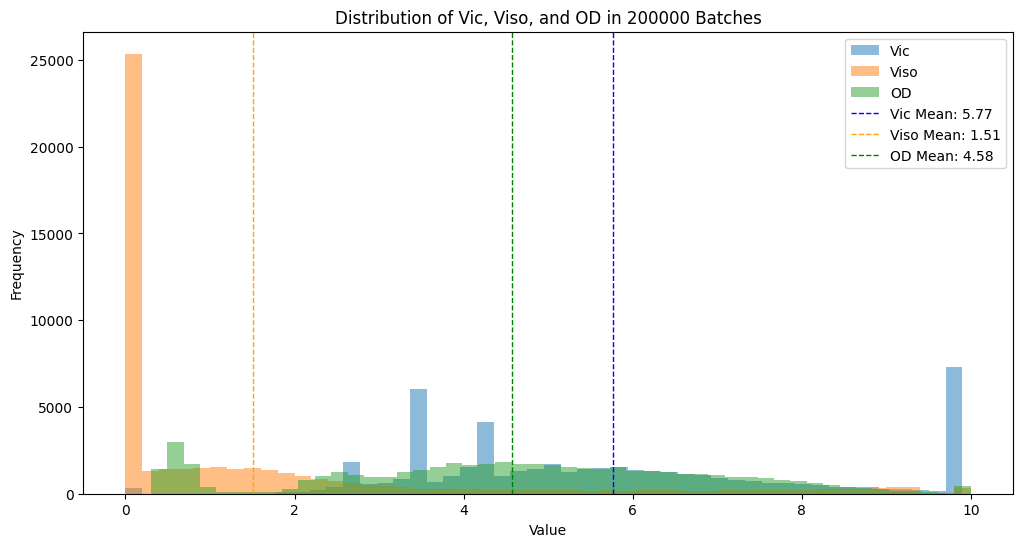

In [ ]:
import sys
import os
import nibabel as nib
import numpy as np
from input_parser import input_parser
from data_loader import load_training_matrix, load_test_matrix, data_combine_matrix
import nibabel.processing
from torch.utils.data import random_split
import time
from tqdm import trange
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import time

# 加载数据的代码
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open(r"/data2/mayupeng/test/dwis_2.txt") as f:
    allDwiNames = f.readlines()
with open(r"/data2/mayupeng/test/masks_2.txt") as f:
    allMaskNames = f.readlines()
allFeatureNames = []
with open(r"/data2/mayupeng/test/icvfs_2.txt") as f:
    allFeatureNames.append(f.readlines())
with open(r"/data2/mayupeng/test/isos_2.txt") as f:
    allFeatureNames.append(f.readlines())
with open(r"/data2/mayupeng/test/ods_2.txt") as f:
    allFeatureNames.append(f.readlines())
allDwiNames = [x.strip("\n") for x in allDwiNames]
allMaskNames = [x.strip("\n") for x in allMaskNames]
for feature_index in range(3):
    allFeatureNames[feature_index] = [
        x.strip("\n") for x in allFeatureNames[feature_index]
    ]

dwiTraining, featurePatchTraining, scales = load_training_matrix(
    allDwiNames,
    allMaskNames,
    allFeatureNames,
    3,
    1,
    3,
    1,
)


indices = torch.randperm(len(dwiTraining))[:50000]
X_test_tensor = torch.from_numpy(dwiTraining[indices]).float()
y_test_tensor = torch.from_numpy(featurePatchTraining[indices]).float()

# 创建测试数据的DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# 计算每个batch中三个指标的分布
num_batches = 200000
batch_size = 128

Vics = []
Visos = []
ODs = []

for i, (X_batch, y_batch) in enumerate(test_loader):
    if i >= num_batches:
        break
    Vic_batch = y_batch[:, 0,:].cpu().numpy()
    Viso_batch = y_batch[:, 1,:].cpu().numpy()
    OD_batch = y_batch[:, 2,:].cpu().numpy()
    
    Vics.extend(Vic_batch)
    Visos.extend(Viso_batch)
    ODs.extend(OD_batch)

Vics = np.array(Vics)
Visos = np.array(Visos)
ODs = np.array(ODs)

# 计算每个batch的平均值
Vic_mean = Vics.mean()
Viso_mean = Visos.mean()
OD_mean = ODs.mean()

# 绘制分布图
plt.figure(figsize=(12, 6))
plt.hist(Vics, bins=50, alpha=0.5, label='Vic')
plt.hist(Visos, bins=50, alpha=0.5, label='Viso')
plt.hist(ODs, bins=50, alpha=0.5, label='OD')
plt.axvline(Vic_mean, color='blue', linestyle='dashed', linewidth=1, label=f'Vic Mean: {Vic_mean:.2f}')
plt.axvline(Viso_mean, color='orange', linestyle='dashed', linewidth=1, label=f'Viso Mean: {Viso_mean:.2f}')
plt.axvline(OD_mean, color='green', linestyle='dashed', linewidth=1, label=f'OD Mean: {OD_mean:.2f}')
plt.legend(loc='upper right')
plt.title('Distribution of Vic, Viso, and OD in 200000 Batches')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


Counting Patches for Subject 0
Counting Voxels for Subject 0
Normalizing Microstructure
Examining Voxels for Subject: 0
scales:
Setting Patch List for Subject: 0


/tmp/ipykernel_746484/1125261122.py:79: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Vic_mode, Vic_count = stats.mode(Vics)
/tmp/ipykernel_746484/1125261122.py:80: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Viso_mode, Viso_count = stats.mode(Visos)
/tmp/ipyker

Vic Mode: [3.4272728] (Count: [21])
Viso Mode: [0.] (Count: [55])
OD Mode: [0.4286939] (Count: [1])


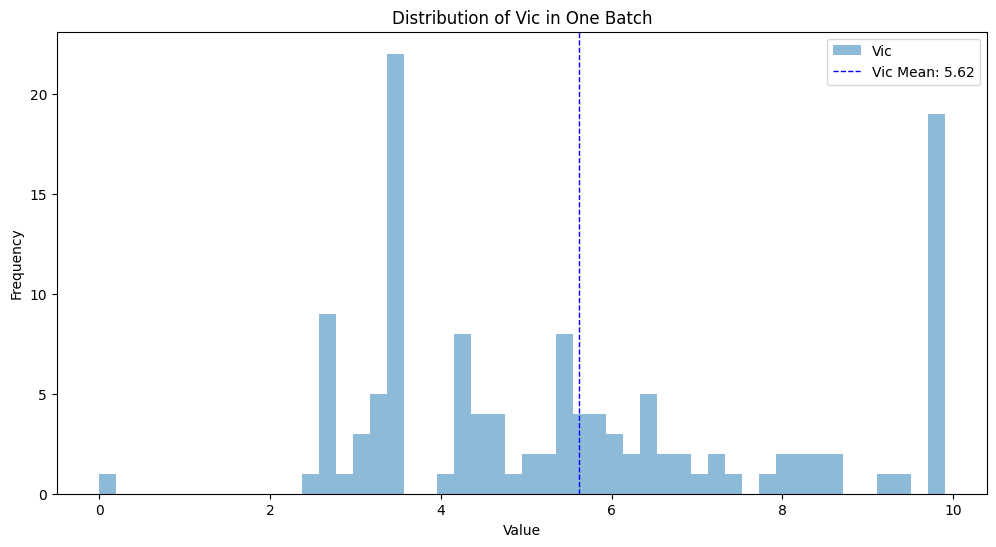

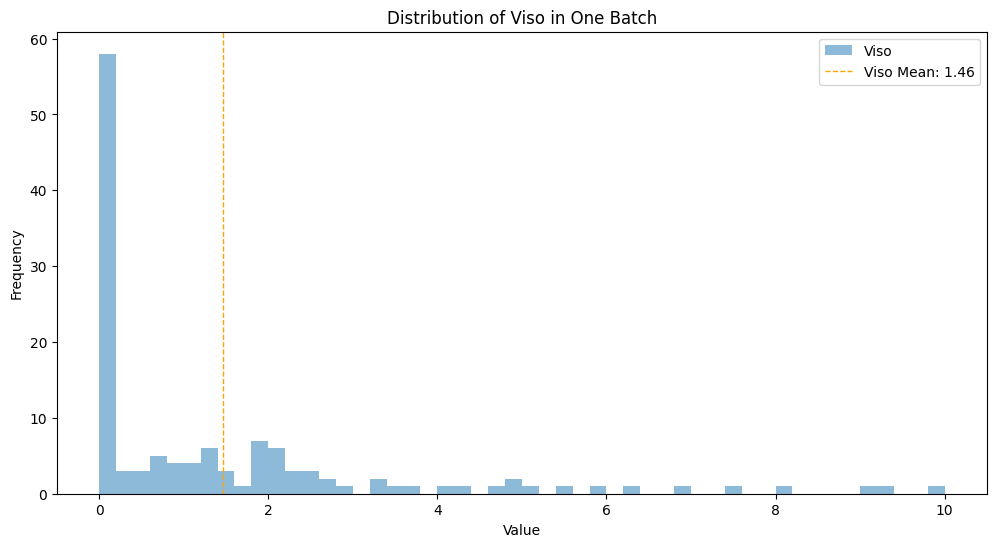

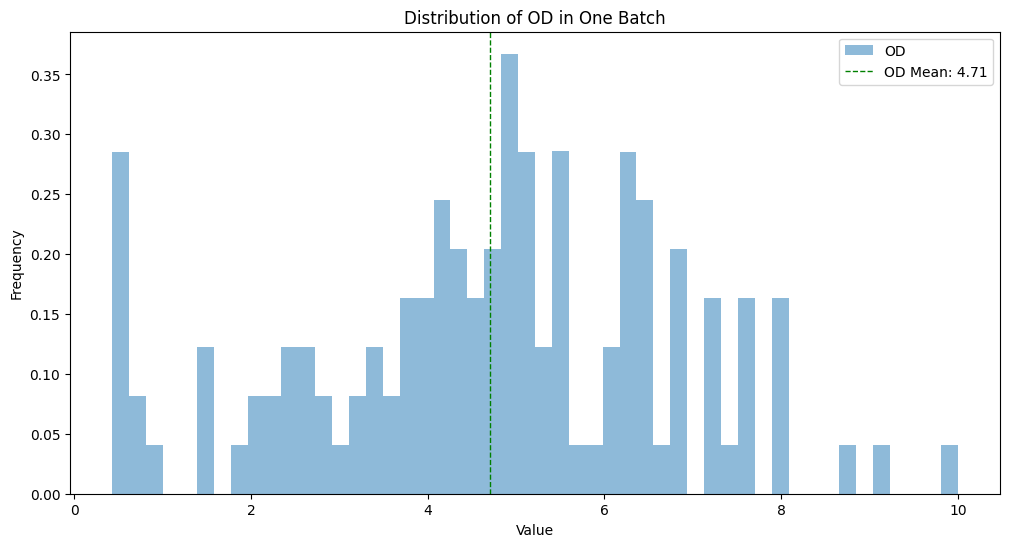

In [ ]:
import sys
import os
import nibabel as nib
import numpy as np
from input_parser import input_parser
from data_loader import load_training_matrix, load_test_matrix, data_combine_matrix
import nibabel.processing
from torch.utils.data import random_split
import time
from tqdm import trange
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import time
from scipy import stats

# 加载数据的代码
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open(r"/data2/mayupeng/test/dwis_2.txt") as f:
    allDwiNames = f.readlines()
with open(r"/data2/mayupeng/test/masks_2.txt") as f:
    allMaskNames = f.readlines()
allFeatureNames = []
with open(r"/data2/mayupeng/test/icvfs_2.txt") as f:
    allFeatureNames.append(f.readlines())
with open(r"/data2/mayupeng/test/isos_2.txt") as f:
    allFeatureNames.append(f.readlines())
with open(r"/data2/mayupeng/test/ods_2.txt") as f:
    allFeatureNames.append(f.readlines())
allDwiNames = [x.strip("\n") for x in allDwiNames]
allMaskNames = [x.strip("\n") for x in allMaskNames]
for feature_index in range(3):
    allFeatureNames[feature_index] = [
        x.strip("\n") for x in allFeatureNames[feature_index]
    ]

dwiTraining, featurePatchTraining, scales = load_training_matrix(
    allDwiNames,
    allMaskNames,
    allFeatureNames,
    3,
    1,
    3,
    1,
)

indices = torch.randperm(len(dwiTraining))[:50000]
X_test_tensor = torch.from_numpy(dwiTraining[indices]).float()
y_test_tensor = torch.from_numpy(featurePatchTraining[indices]).float()

# 创建测试数据的DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)


Vics = []
Visos = []
ODs = []

for i, (X_batch, y_batch) in enumerate(test_loader):
    if i > 0:
        break
    Vic_batch = y_batch[:, 0,:].cpu().numpy()
    Viso_batch = y_batch[:, 1,:].cpu().numpy()
    OD_batch = y_batch[:, 2,:].cpu().numpy()
    
    Vics.extend(Vic_batch)
    Visos.extend(Viso_batch)
    ODs.extend(OD_batch)

Vics = np.array(Vics)
Visos = np.array(Visos)
ODs = np.array(ODs)

Vic_mode, Vic_count = stats.mode(Vics)
Viso_mode, Viso_count = stats.mode(Visos)
OD_mode, OD_count = stats.mode(ODs)

# 计算每个batch的平均值
Vic_mean = Vics.mean()
Viso_mean = Visos.mean()
OD_mean = ODs.mean()

# 打印众数和出现次数
print(f'Vic Mode: {Vic_mode[0]} (Count: {Vic_count[0]})')
print(f'Viso Mode: {Viso_mode[0]} (Count: {Viso_count[0]})')
print(f'OD Mode: {OD_mode[0]} (Count: {OD_count[0]})')

# 打印详细分布信息
print("Detailed Frequency Count for OD Values:")
unique, counts = np.unique(ODs, return_counts=True)
for u, c in zip(unique, counts):
    print(f'Value: {u}, Count: {c}')

# 绘制 Vic 分布图
plt.figure(figsize=(12, 6))
plt.hist(Vics, bins=50, alpha=0.5, label='Vic')
plt.axvline(Vic_mean, color='blue', linestyle='dashed', linewidth=1, label=f'Vic Mean: {Vic_mean:.2f}')
plt.legend(loc='upper right')
plt.title('Distribution of Vic in One Batch')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# 绘制 Viso 分布图
plt.figure(figsize=(12, 6))
plt.hist(Visos, bins=50, alpha=0.5, label='Viso')
plt.axvline(Viso_mean, color='orange', linestyle='dashed', linewidth=1, label=f'Viso Mean: {Viso_mean:.2f}')
plt.legend(loc='upper right')
plt.title('Distribution of Viso in One Batch')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# 绘制 OD 分布图
plt.figure(figsize=(12, 6))
plt.hist(ODs, bins=50, alpha=0.5, range=(ODs.min(), ODs.max()), density=True, label='OD')
plt.axvline(OD_mean, color='green', linestyle='dashed', linewidth=1, label=f'OD Mean: {OD_mean:.2f}')
plt.legend(loc='upper right')
plt.title('Distribution of OD in 1000 Batches')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [ ]:

# 设置离散化的精度
precision = 2
bin_width = 10 ** -precision  # 例如，precision=2 时，bin_width=0.01

# 离散化数据
Vics = np.round(Vics / bin_width) * bin_width
Visos = np.round(Visos / bin_width) * bin_width
ODs = np.round(ODs / bin_width) * bin_width

# 计算众数和出现次数
Vic_mode, Vic_count = stats.mode(Vics)
Viso_mode, Viso_count = stats.mode(Visos)
OD_mode, OD_count = stats.mode(ODs)

# 计算每个batch的平均值
Vic_mean = Vics.mean()
Viso_mean = Visos.mean()
OD_mean = ODs.mean()

# 打印众数和出现次数
print(f'Vic Mode: {Vic_mode[0]:.{precision}f} (Count: {Vic_count[0]})')
print(f'Viso Mode: {Viso_mode[0]:.{precision}f} (Count: {Viso_count[0]})')
print(f'OD Mode: {OD_mode[0]:.{precision}f} (Count: {OD_count[0]})')

# 打印详细分布信息
print("Detailed Frequency Count for OD Values:")
unique, counts = np.unique(ODs, return_counts=True)
for u, c in zip(unique, counts):
    print(f'Value: {u:.{precision}f}, Count: {c}')

# 绘制 Vic 分布图
plt.figure(figsize=(12, 6))
plt.hist(Vics, bins=int((Vics.max() - Vics.min()) / bin_width), alpha=0.5, label='Vic')
plt.axvline(Vic_mean, color='blue', linestyle='dashed', linewidth=1, label=f'Vic Mean: {Vic_mean:.2f}')
plt.legend(loc='upper right')
plt.title('Distribution of Vic in 1000 Batches')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# 绘制 Viso 分布图
plt.figure(figsize=(12, 6))
plt.hist(Visos, bins=int((Visos.max() - Visos.min()) / bin_width), alpha=0.5, label='Viso')
plt.axvline(Viso_mean, color='orange', linestyle='dashed', linewidth=1, label=f'Viso Mean: {Viso_mean:.2f}')
plt.legend(loc='upper right')
plt.title('Distribution of Viso in 1000 Batches')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# 绘制 OD 分布图
plt.figure(figsize=(12, 6))
plt.hist(ODs, bins=int((ODs.max() - ODs.min()) / bin_width), alpha=0.5, label='OD')
plt.axvline(OD_mean, color='green', linestyle='dashed', linewidth=1, label=f'OD Mean: {OD_mean:.2f}')
plt.legend(loc='upper right')
plt.title('Distribution of OD in 1000 Batches')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_746484/3269452251.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Vic_mode, Vic_count = stats.mode(Vics)
/tmp/ipykernel_746484/3269452251.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Viso_mode, Viso_count = stats.mode(Visos)
/tmp/ipyker

TypeError: unsupported format string passed to numpy.ndarray.__format__

In [ ]:
import torch
import torch.nn as nn
import scipy.stats.stats as stats
import numpy as np

def get_tiedrank(batch_score, dim=0):
    batch_score = batch_score.cpu()
    rank = stats.rankdata(batch_score)
    rank = stats.rankdata(rank) - 1
    rank = (rank * -1) + batch_score.size(dim)
    rank = torch.from_numpy(rank).cuda()
    rank = rank.float()
    rank = rank / batch_score.size(dim)
    return rank

def comp(inpu):
    
    print("input_size: ",inpu.size(0))
    in_mat1 = torch.triu(inpu.repeat(inpu.size(0), 1), diagonal=1)
    print("in_mat1:", in_mat1)
    
    in_mat2 = torch.triu(inpu.repeat(inpu.size(0), 1).t(), diagonal=1)
    print("in_mat2:", in_mat2)
    
    comp_first = (in_mat1 - in_mat2)
    print("comp_first:", comp_first)
    
    comp_second = (in_mat2 - in_mat1)
    print("comp_second:", comp_second)
    
    std1 = torch.std(comp_first).item()
    std2 = torch.std(comp_second).item()
    print("std1:", std1)
    print("std2:", std2)
    
    comp_first = torch.sigmoid(comp_first * (6.8 / std1))
    print("comp_first (sigmoid):", comp_first)
    
    comp_second = torch.sigmoid(comp_second * (6.8 / std2))
    print("comp_second (sigmoid):", comp_second)
    
    comp_first = torch.triu(comp_first, diagonal=1)
    print("comp_first (triu):", comp_first)
    
    comp_second = torch.triu(comp_second, diagonal=1)
    print("comp_second (triu):", comp_second)
    
    result = (torch.sum(comp_first, 1) + torch.sum(comp_second, 0) + 1) / inpu.size(0)
    print("result:", result)
    
    return result


# 示例输入
input_ = torch.randn(64, 1)
output = comp(input_)
print(output.shape)
#print("output:", output)

#rank_gt = get_tiedrank(input_)
#print(rank_gt)



input_size:  64
in_mat1: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])
in_mat2: tensor([[ 0.0000, -0.5974, -1.9459,  ...,  0.3919,  0.1754, -0.8951]])
comp_first: tensor([[ 0.0000,  0.5974,  1.9459,  ..., -0.3919, -0.1754,  0.8951],
        [ 0.0000,  0.5974,  1.9459,  ..., -0.3919, -0.1754,  0.8951],
        [ 0.0000,  0.5974,  1.9459,  ..., -0.3919, -0.1754,  0.8951],
        ...,
        [ 0.0000,  0.5974,  1.9459,  ..., -0.3919, -0.1754,  0.8951],
        [ 0.0000,  0.5974,  1.9459,  ..., -0.3919, -0.1754,  0.8951],
        [ 0.0000,  0.5974,  1.9459,  ..., -0.3919, -0.1754,  0.8951]])
comp_second: tensor([[ 0.0000, -0.5974, -1.9459,  ...,  0.3919,  0.1754, -0.8951],
        [ 0.0000, -0.5974, -1.9459,  ...,  0.3919,  0.1754, -0.8951],
        [ 0.0000, -0.5974, -1.9459,  ...,  0.3919,  0.1754, -0.8951],
        ...,
        [ 0.0000, -0.5974, -1.9459,  ...,  0.3919,  0.1754, -0.8951],
        [ 0.0000, -0.5974, -1.9459,  ...,  0.

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import scipy.stats.stats as stats
import numpy as np



class SpearmanLoss(torch.nn.Module):
    """Loss function  inspired by spearmann correlation.self
    Required the trained model to have a good initlization.

    Set lbd to 1 for a few epoch to help with the initialization.
    """

    def __init__(self, sorter_type, seq_len=None, sorter_state_dict=None, lbd=1):
        super(SpearmanLoss, self).__init__()
        self.sorter = model_loader(sorter_type, seq_len, sorter_state_dict)

        self.criterion_mse = torch.nn.MSELoss()
        self.criterionl1 = torch.nn.L1Loss()

        self.lbd = lbd

    def forward(self, mem_pred, mem_gt, pr=False):
        rank_gt = get_tiedrank(mem_gt)

        rank_pred = self.sorter(mem_pred.unsqueeze(0)).view(-1)

        return self.criterion_mse(rank_pred, rank_gt) + self.lbd * self.criterionl1(
            mem_pred, mem_gt
        )

def get_tiedrank(batch_score, dim=0):
    batch_score = batch_score.cpu()
    
    rank = stats.rankdata(batch_score)
    rank = stats.rankdata(rank) - 1
    rank = (rank * -1) + batch_score.size(dim)
    rank = torch.from_numpy(rank).cuda()
    rank = rank.float()
    rank = rank / batch_score.size(dim)
    return rank


def model_loader(model_type, seq_len, pretrained_state_dict=None):
    if model_type == "lstm":
        model = lstm_baseline(seq_len)
    elif model_type == "lstmla":
        model = lstm_large(seq_len)
    elif model_type == "lstme":
        model = lstm_end(seq_len)
    elif model_type == "mlp":
        model = mlp(seq_len)

    else:
        raise Exception("Model type unknown", model_type)

    if pretrained_state_dict is not None:
        model.load_state_dict(pretrained_state_dict)

    return model





class lstm_large(nn.Module):
    def __init__(self, seq_len):
        super(lstm_large, self).__init__()
        self.lstm = nn.LSTM(1, 512, 2, batch_first=True, bidirectional=True)
        self.conv1 = nn.Conv1d(seq_len, seq_len, 1024)

    def forward(self, input_):
        input_ = input_.reshape(input_.size(0), -1, 1)
        out, _ = self.lstm(input_)
        out = self.conv1(out)

        return out.view(input_.size(0), -1)
    

def load_sorter(checkpoint_path):
    sorter_checkpoint = torch.load(checkpoint_path)

    model_type = sorter_checkpoint["args_dict"].model_type
    seq_len = sorter_checkpoint["args_dict"].seq_len
    state_dict = sorter_checkpoint["state_dict"]

    return model_type, seq_len, state_dict  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model_loader(*load_sorter(checkpoint_path="/data2/mayupeng/Loss/weights/real_model.pth.tar")).to(device) 
rand_data = torch.rand(64,1).to(device)

uniform_labels = torch.linspace(0, 1, steps=64).unsqueeze(-1).to(device)  # (64,1)
scaled_rand_data = rand_data * 10
scaled_uniform_labels = uniform_labels * 10                                 
mem_pred_enhanced = torch.cat([scaled_rand_data, scaled_uniform_labels], dim=0)  # (128, 1)
mem_gt_enhanced = torch.cat([scaled_rand_data, scaled_uniform_labels], dim=0)  # (128, 1)

print(mem_pred_enhanced.shape)
print(mem_gt_enhanced.shape)

rank_gt = get_tiedrank(mem_gt_enhanced)
print(rank_gt.shape)

rank_pred = model(mem_pred_enhanced.unsqueeze(0)).view(-1)
print(rank_pred.shape)

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128])
torch.Size([1, 128])


/tmp/ipykernel_10539/3408393456.py:38: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  rank = stats.rankdata(batch_score)
/tmp/ipykernel_10539/3408393456.py:39: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  rank = stats.rankdata(rank) - 1


In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available!")
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
else:
    print("CUDA is not available.")


CUDA is not available.


In [ ]:
import torch

def get_tiedrank(batch_score, dim=0):
    batch_score = batch_score.cpu()
    
    rank = stats.rankdata(batch_score)
    rank = stats.rankdata(rank) - 1
    rank = (rank * -1) + batch_score.size(dim)
    rank = torch.from_numpy(rank).cuda()
    rank = rank.float()
    rank = rank / batch_score.size(dim)
    return rank

def comp(inpu):
    print("input_size: ",inpu.size(0))
    in_mat1 = torch.triu(inpu.repeat(inpu.size(0), 1), diagonal=1)
    print("in_mat1:", in_mat1)
    
    in_mat2 = torch.triu(inpu.repeat(inpu.size(0), 1).t(), diagonal=1)
    print("in_mat2:", in_mat2)
    
    comp_first = (in_mat1 - in_mat2)
    print("comp_first:", comp_first)
    
    comp_second = (in_mat2 - in_mat1)
    print("comp_second:", comp_second)
    
    std1 = torch.std(comp_first).item()
    std2 = torch.std(comp_second).item()
    print("std1:", std1)
    print("std2:", std2)
    
    comp_first = torch.sigmoid(comp_first * (6.8 / std1))
    print("comp_first (sigmoid):", comp_first)
    
    comp_second = torch.sigmoid(comp_second * (6.8 / std2))
    print("comp_second (sigmoid):", comp_second)
    
    comp_first = torch.triu(comp_first, diagonal=1)
    print("comp_first (triu):", comp_first)
    
    comp_second = torch.triu(comp_second, diagonal=1)
    print("comp_second (triu):", comp_second)
    
    result = (torch.sum(comp_first, 1) + torch.sum(comp_second, 0) + 1) / inpu.size(0)
    print("result:", result)
    
    return result
def get_rank(batch_score, dim=0):
    rank = torch.argsort(batch_score, dim=dim)
    rank = torch.argsort(rank, dim=dim)
    rank = (rank * -1) + batch_score.size(dim)
    rank = rank.float()
    rank = rank / batch_score.size(dim)

    return rank
# 示例输入
inpu = torch.randn(64, 1)
output = get_rank(inpu)
print("output:", output)
output = comp(inpu)
print("output:", output)


output: tensor([[0.3750],
        [0.4688],
        [0.7344],
        [0.9375],
        [0.1719],
        [0.6406],
        [0.5781],
        [0.2031],
        [0.2188],
        [0.0781],
        [0.8125],
        [0.9062],
        [0.9219],
        [0.8438],
        [0.8906],
        [0.2969],
        [0.5312],
        [0.6094],
        [0.4375],
        [0.0938],
        [0.5469],
        [0.3438],
        [0.9688],
        [0.6250],
        [0.4531],
        [0.9531],
        [0.1250],
        [0.1406],
        [0.6719],
        [0.5156],
        [0.8594],
        [0.2500],
        [0.7500],
        [1.0000],
        [0.3125],
        [0.0312],
        [0.0469],
        [0.1562],
        [0.7812],
        [0.2344],
        [0.0625],
        [0.3594],
        [0.2656],
        [0.4062],
        [0.4844],
        [0.7969],
        [0.3281],
        [0.4219],
        [0.8281],
        [0.1094],
        [0.5938],
        [0.9844],
        [0.5000],
        [0.1875],
        [0.7656],
  

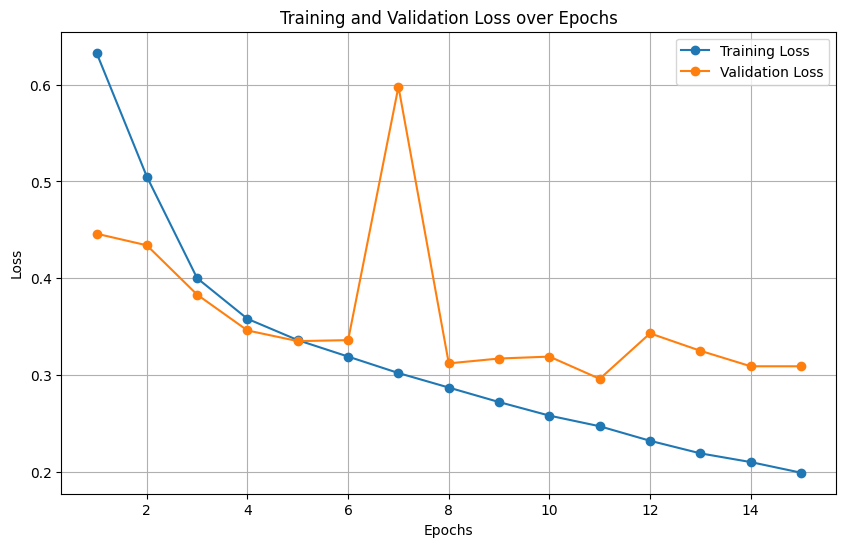

In [ ]:
import matplotlib.pyplot as plt

# Data from the table
epochs = list(range(1, 16))
training_loss = [0.633, 0.505, 0.4, 0.358, 0.336, 0.319, 0.302, 0.287, 0.272, 0.258, 0.247, 0.232, 0.219, 0.21, 0.199]
validation_loss = [0.446, 0.434, 0.383, 0.346, 0.335, 0.336, 0.598, 0.312, 0.317, 0.319, 0.296, 0.343, 0.325, 0.309, 0.309]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
import torch
import torchsummary
from testmodel_linear_modi_v2 import Mymodel
import torch.nn as nn
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Mymodel().to(device)
torchsummary.summary(model, input_size=(60, 27))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 60, 64]           1,792
              ReLU-2               [-1, 60, 64]               0
            Linear-3              [-1, 60, 128]           8,320
              ReLU-4              [-1, 60, 128]               0
            Linear-5              [-1, 60, 256]          33,024
              ReLU-6              [-1, 60, 256]               0
            Linear-7              [-1, 60, 512]         131,584
              ReLU-8              [-1, 60, 512]               0
       LambdaLayer-9              [-1, 512, 60]               0
           Linear-10              [-1, 512, 64]           3,904
             ReLU-11              [-1, 512, 64]               0
           Linear-12             [-1, 512, 128]           8,320
             ReLU-13             [-1, 512, 128]               0
           Linear-14             [-1, 5

In [1]:
import os
import shutil

# 假设这是对应的 subject_ids 列表
subject_ids = [
    "101107", "101309", "101410", "101915", "102008",
    "102109", "102311", "102513", "102614", "102715",
    "102816", "103010", "103111", "103212", "103414",
    "103515", "103818", "104012", "104416", "104820"
]

# 假设这是保存文件的目录
directory = '/data2/mayupeng/ye/test_MEDN'

# 目标根目录
output_root_dir = "/path/to/output"  # 修改为实际的目标根目录

# 假设您保存了 20 个 subject
n_subjects = 20

# 遍历所有 subject 保存的文件路径，并将它们重命名和重新保存
for i in range(n_subjects):
    # 获取对应的 subject_id
    subject_id = subject_ids[i]
    
    # 构建新的保存目录 subject_id/NODDI/
    new_dir = os.path.join(output_root_dir, subject_id, "NODDI")
    os.makedirs(new_dir, exist_ok=True)

    # 原始文件路径
    icvf_name = os.path.join(directory, f"DN_AMICO_ICVF_sub_{i}.nii.gz")
    iso_name = os.path.join(directory, f"DN_AMICO_ISO_sub_{i}.nii.gz")
    od_name = os.path.join(directory, f"DN_AMICO_OD_sub_{i}.nii.gz")

    # 新的文件路径
    new_icvf_name = os.path.join(new_dir, "FIT_ICVF.nii.gz")
    new_iso_name = os.path.join(new_dir, "FIT_ISOVF.nii.gz")
    new_od_name = os.path.join(new_dir, "FIT_OD.nii.gz")

    # 复制文件到新路径
    shutil.copy(icvf_name, new_icvf_name)
    shutil.copy(iso_name, new_iso_name)
    shutil.copy(od_name, new_od_name)

    # 打印转换的信息
    print(f"ICVF 文件保存到: {new_icvf_name}")
    print(f"ISO 文件保存到: {new_iso_name}")
    print(f"OD 文件保存到: {new_od_name}")


文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/new/101107/NODDI/FIT_ICVF.nii.gz
文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/new/101107/NODDI/FIT_OD.nii.gz
文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/new/101107/NODDI/FIT_ISOVF.nii.gz
文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/new/101107/NODDI/FIT_ICVF.nii.gz
文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/new/101107/NODDI/FIT_OD.nii.gz
文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/new/101107/NODDI/FIT_ISOVF.nii.gz
文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/new/101107/NODDI/FIT_ICVF.nii.gz
文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/new/101107/NODDI/FIT_OD.nii.gz
文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/new/101107/NODDI/FIT_ISOVF.nii.gz
文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/new/101309/NODDI/FIT_ICVF.nii.gz
文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/new/101309/NODDI/FIT_OD.nii.gz
文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/new/101309/NODDI/FIT_ISOVF.nii.gz
文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/new/101309/NODDI/FIT_ICVF.nii.gz
文件已重命名并保存到: /data2/mayupeng/ye/test_MEDN/n

In [2]:
import numpy as np
import os

def read_bvec_bval(folder_path):
    """读取bvec和bval文件"""
    bvec_file = os.path.join(folder_path, 'dti.bvec')
    bval_file = os.path.join(folder_path, 'dti.bval')
    
    bvecs = np.loadtxt(bvec_file)
    bvals = np.loadtxt(bval_file)
    
    return bvecs, bvals

def calculate_angle_diff(bvec1, bvec2):
    """计算两个bvec的角度差"""
    dot_product = np.dot(bvec1, bvec2)
    # 如果点积为负值，取反
    if dot_product < 0:
        dot_product = -dot_product
    angle = np.arccos(dot_product) * (180 / np.pi)
    return angle

def find_closest_bvec(bvec, bval, target_bvecs, target_bvals, tolerance=25):
    """找到与给定bvec最接近的bvec，按照bval匹配，bval误差容忍度为tolerance"""
    min_angle = float('inf')
    closest_bvec = None
    
    for i in range(len(target_bvals)):
        if abs(target_bvals[i] - bval) <= tolerance:
            candidate_bvec = target_bvecs[:, i]
            angle_diff = calculate_angle_diff(bvec, candidate_bvec)
            if angle_diff < min_angle:
                min_angle = angle_diff
                closest_bvec = candidate_bvec
                
    return min_angle

def compute_avg_angle_diff(person_bvecs, person_bvals, other_bvecs, other_bvals):
    """计算第一个人的所有bvec与第二个人的最小角度差的平均值"""
    min_angle_diffs = []
    
    for bvec, bval in zip(person_bvecs.T, person_bvals):
        min_angle = find_closest_bvec(bvec, bval, other_bvecs, other_bvals)
        min_angle_diffs.append(min_angle)
    
    avg_angle_diff = np.mean(min_angle_diffs)
    return avg_angle_diff

def calculate_max_diff(files_folder):
    """计算五个人之间的最大差异上界"""
    all_bvecs = {}
    all_bvals = {}

    for person_folder in files_folder:
        bvecs, bvals = read_bvec_bval(person_folder)
        all_bvecs[person_folder] = bvecs
        all_bvals[person_folder] = bvals

    angle_diffs = []
    pairwise_diffs = {}
    for i, person_folder in enumerate(files_folder):
        person_bvecs = all_bvecs[person_folder]
        person_bvals = all_bvals[person_folder]
        
        for j, other_person_folder in enumerate(files_folder):
            if person_folder != other_person_folder:
                other_bvecs = all_bvecs[other_person_folder]
                other_bvals = all_bvals[other_person_folder]
                
                avg_diff = compute_avg_angle_diff(person_bvecs, person_bvals, other_bvecs, other_bvals)
                angle_diffs.append(avg_diff)
                
                pairwise_diffs[(person_folder, other_person_folder)] = avg_diff
    
    print("五个人两两之间的平均角度差异：")
    for (person1, person2), avg_diff in pairwise_diffs.items():
        print(f"{person1} 与 {person2} 之间的平均角度差异: {avg_diff:.2f} 度")
        
    max_diff = max(angle_diffs)
    return max_diff

# 文件夹路径
files_folder = [r'E:\HCP_25\101107', r'E:\HCP_25\101309', r'E:\HCP_25\101410', r'E:\HCP_25\101915', r'E:\HCP_25\102008']

max_diff = calculate_max_diff(files_folder)
print(f"最大平均差异: {max_diff}")


五个人两两之间的平均角度差异：
E:\HCP_25\101107 与 E:\HCP_25\101309 之间的平均角度差异: 4.07 度
E:\HCP_25\101107 与 E:\HCP_25\101410 之间的平均角度差异: 2.78 度
E:\HCP_25\101107 与 E:\HCP_25\101915 之间的平均角度差异: 4.23 度
E:\HCP_25\101107 与 E:\HCP_25\102008 之间的平均角度差异: 6.89 度
E:\HCP_25\101309 与 E:\HCP_25\101107 之间的平均角度差异: 4.14 度
E:\HCP_25\101309 与 E:\HCP_25\101410 之间的平均角度差异: 3.64 度
E:\HCP_25\101309 与 E:\HCP_25\101915 之间的平均角度差异: 5.22 度
E:\HCP_25\101309 与 E:\HCP_25\102008 之间的平均角度差异: 7.16 度
E:\HCP_25\101410 与 E:\HCP_25\101107 之间的平均角度差异: 2.77 度
E:\HCP_25\101410 与 E:\HCP_25\101309 之间的平均角度差异: 3.56 度
E:\HCP_25\101410 与 E:\HCP_25\101915 之间的平均角度差异: 4.45 度
E:\HCP_25\101410 与 E:\HCP_25\102008 之间的平均角度差异: 6.11 度
E:\HCP_25\101915 与 E:\HCP_25\101107 之间的平均角度差异: 4.21 度
E:\HCP_25\101915 与 E:\HCP_25\101309 之间的平均角度差异: 5.22 度
E:\HCP_25\101915 与 E:\HCP_25\101410 之间的平均角度差异: 4.44 度
E:\HCP_25\101915 与 E:\HCP_25\102008 之间的平均角度差异: 7.46 度
E:\HCP_25\102008 与 E:\HCP_25\101107 之间的平均角度差异: 6.03 度
E:\HCP_25\102008 与 E:\HCP_25\101309 之间的平均角度差异: 6.32 度
E:\HCP_25\10

In [10]:
import numpy as np
import os

def read_bvec_bval(folder_path):
    """读取bvec和bval文件"""
    bvec_file = os.path.join(folder_path, 'dti.bvec')
    bval_file = os.path.join(folder_path, 'dti.bval')
    
    bvecs = np.loadtxt(bvec_file)
    bvals = np.loadtxt(bval_file)
    
    return bvecs, bvals

def calculate_angle_diff(bvec1, bvec2):
    """计算两个bvec的角度差"""
    # 计算点积，bvec1和bvec2已经是单位向量
    dot_product = np.dot(bvec1, bvec2)
    # 如果点积为负值，取反
    if dot_product < 0:
        dot_product = -dot_product
    # 计算角度差
    angle = np.arccos(dot_product) * (180 / np.pi)
    return angle

def find_closest_bvec(bvec, bval, target_bvecs, target_bvals, tolerance=50):
    """找到与给定bvec最接近的bvec，按照bval匹配，bval误差容忍度为tolerance"""
    min_angle = float('inf')
    closest_bvec = None
    
    # 遍历目标人的数据，找到bval相等且点积最小的bvec
    for i in range(len(target_bvals)):
        if abs(target_bvals[i] - bval) <= tolerance:
            candidate_bvec = target_bvecs[:, i]
            angle_diff = calculate_angle_diff(bvec, candidate_bvec)
            if angle_diff < min_angle:
                min_angle = angle_diff
                closest_bvec = candidate_bvec
                
    return min_angle

def compute_avg_angle_diff(person_bvecs, person_bvals, other_bvecs, other_bvals):
    """计算第一个人的所有bvec与第二个人的最小角度差的平均值"""
    min_angle_diffs = []
    
    # 遍历第一个人的所有bvec
    for bvec, bval in zip(person_bvecs.T, person_bvals):
        # 找到第二个人中与当前bvec角度最小的bvec
        min_angle = find_closest_bvec(bvec, bval, other_bvecs, other_bvals)
        min_angle_diffs.append(min_angle)
    
    # 计算288个bvec的角度差平均值
    avg_angle_diff = np.mean(min_angle_diffs)
    return avg_angle_diff, min_angle_diffs

def calculate_max_diff(files_folder):
    """计算五个人之间的最大差异上界"""
    all_bvecs = {}
    all_bvals = {}

    # 读取所有人的数据
    for person_folder in files_folder:
        bvecs, bvals = read_bvec_bval(person_folder)
        all_bvecs[person_folder] = bvecs
        all_bvals[person_folder] = bvals

    # 计算每个人与其他人的差异
    angle_diffs = []
    pairwise_diffs = {}

    for i, person_folder in enumerate(files_folder):
        person_bvecs = all_bvecs[person_folder]
        person_bvals = all_bvals[person_folder]
        
        # 与其他四个人计算差异
        for j, other_person_folder in enumerate(files_folder):
            if person_folder != other_person_folder:
                other_bvecs = all_bvecs[other_person_folder]
                other_bvals = all_bvals[other_person_folder]
                
                # 计算该对人的角度差，并返回min_angle_diffs
                avg_diff, min_angle_diffs = compute_avg_angle_diff(person_bvecs, person_bvals, other_bvecs, other_bvals)
                angle_diffs.append(avg_diff)
                
                # 保存每对人之间的平均角度差
                pairwise_diffs[(person_folder, other_person_folder)] = avg_diff
                
                # 打印该对人之间的min_angle_diffs中的最大值
                max_min_angle_diff = np.max(min_angle_diffs)
                print(f"{person_folder} 与 {other_person_folder} 之间的min_angle_diffs中的最大值: {max_min_angle_diff:.2f} 度")

    # 打印每两个人之间的平均角度差异
    print("\n五个人两两之间的平均角度差异：")
    for (person1, person2), avg_diff in pairwise_diffs.items():
        print(f"{person1} 与 {person2} 之间的平均角度差异: {avg_diff:.2f} 度")

    # 返回最大差异上界
    max_diff = max(angle_diffs)
    return max_diff

# 文件夹路径
files_folder = [r'E:\HCP_25\101107', r'E:\HCP_25\101309', r'E:\HCP_25\101410', r'E:\HCP_25\101915', r'E:\HCP_25\102008']

# 计算五个人的最大差异上界
max_diff = calculate_max_diff(files_folder)
print(f"\n最大差异上界: {max_diff:.2f} 度")


E:\HCP_25\101107 与 E:\HCP_25\101309 之间的min_angle_diffs中的最大值: 7.18 度
E:\HCP_25\101107 与 E:\HCP_25\101410 之间的min_angle_diffs中的最大值: 4.06 度
E:\HCP_25\101107 与 E:\HCP_25\101915 之间的min_angle_diffs中的最大值: 8.01 度
E:\HCP_25\101107 与 E:\HCP_25\102008 之间的min_angle_diffs中的最大值: 13.24 度
E:\HCP_25\101309 与 E:\HCP_25\101107 之间的min_angle_diffs中的最大值: 7.17 度
E:\HCP_25\101309 与 E:\HCP_25\101410 之间的min_angle_diffs中的最大值: 5.63 度
E:\HCP_25\101309 与 E:\HCP_25\101915 之间的min_angle_diffs中的最大值: 7.80 度
E:\HCP_25\101309 与 E:\HCP_25\102008 之间的min_angle_diffs中的最大值: 14.11 度
E:\HCP_25\101410 与 E:\HCP_25\101107 之间的min_angle_diffs中的最大值: 4.06 度
E:\HCP_25\101410 与 E:\HCP_25\101309 之间的min_angle_diffs中的最大值: 5.63 度
E:\HCP_25\101410 与 E:\HCP_25\101915 之间的min_angle_diffs中的最大值: 6.20 度
E:\HCP_25\101410 与 E:\HCP_25\102008 之间的min_angle_diffs中的最大值: 13.75 度
E:\HCP_25\101915 与 E:\HCP_25\101107 之间的min_angle_diffs中的最大值: 7.36 度
E:\HCP_25\101915 与 E:\HCP_25\101309 之间的min_angle_diffs中的最大值: 7.49 度
E:\HCP_25\101915 与 E:\HCP_25\101410 之间的min_an

In [9]:
import numpy as np
import os

def read_bvec_bval(folder_path):
    """读取bvec和bval文件"""
    bvec_file = os.path.join(folder_path, 'dti.bvec')
    bval_file = os.path.join(folder_path, 'dti.bval')
    
    bvecs = np.loadtxt(bvec_file)
    bvals = np.loadtxt(bval_file)
    
    return bvecs, bvals

def calculate_angle_diff(bvec1, bvec2):
    """计算两个bvec的角度差"""
    # 计算点积，bvec1和bvec2已经是单位向量
    dot_product = np.dot(bvec1, bvec2)
    # 如果点积为负值，取反
    if dot_product < 0:
        dot_product = -dot_product
    # 计算角度差
    angle = np.arccos(dot_product) * (180 / np.pi)
    return angle

def find_closest_bvec(bvec, bval, target_bvecs, target_bvals, tolerance=50):
    """找到与给定bvec最接近的bvec，按照bval匹配，bval误差容忍度为tolerance"""
    min_angle = float('inf')
    closest_bvec = None
    
    # 遍历目标人的数据，找到bval相等且点积最小的bvec
    for i in range(len(target_bvals)):
        if abs(target_bvals[i] - bval) <= tolerance:
            candidate_bvec = target_bvecs[:, i]
            angle_diff = calculate_angle_diff(bvec, candidate_bvec)
            if angle_diff < min_angle:
                min_angle = angle_diff
                closest_bvec = candidate_bvec
                
    return min_angle

def compute_avg_angle_diff(person_bvecs, person_bvals, other_bvecs, other_bvals):
    """计算第一个人的所有bvec与第二个人的最小角度差的平均值"""
    min_angle_diffs = []
    
    # 遍历第一个人的所有bvec
    for bvec, bval in zip(person_bvecs.T, person_bvals):
        # 找到第二个人中与当前bvec角度最小的bvec
        min_angle = find_closest_bvec(bvec, bval, other_bvecs, other_bvals)
        min_angle_diffs.append(min_angle)
    
    # 计算288个bvec的角度差平均值
    avg_angle_diff = np.mean(min_angle_diffs)
    return avg_angle_diff, min_angle_diffs

def calculate_max_diff(files_folder):
    """计算五个人之间的最大差异上界"""
    all_bvecs = {}
    all_bvals = {}

    # 读取所有人的数据
    for person_folder in files_folder:
        bvecs, bvals = read_bvec_bval(person_folder)
        all_bvecs[person_folder] = bvecs
        all_bvals[person_folder] = bvals

    # 计算每个人与其他人的差异
    angle_diffs = []
    pairwise_diffs = {}

    for i, person_folder in enumerate(files_folder):
        person_bvecs = all_bvecs[person_folder]
        person_bvals = all_bvals[person_folder]
        
        # 与其他四个人计算差异
        for j, other_person_folder in enumerate(files_folder):
            if person_folder < other_person_folder:  # 保证顺序一致，避免重复计算
                other_bvecs = all_bvecs[other_person_folder]
                other_bvals = all_bvals[other_person_folder]
                
                # 计算该对人的角度差，并返回min_angle_diffs
                avg_diff, min_angle_diffs = compute_avg_angle_diff(person_bvecs, person_bvals, other_bvecs, other_bvals)
                angle_diffs.append(avg_diff)
                
                # 保存每对人之间的平均角度差
                pairwise_diffs[(person_folder, other_person_folder)] = avg_diff
                
                # 打印该对人之间的min_angle_diffs中的最大值
                max_min_angle_diff = np.max(min_angle_diffs)
                print(f"{person_folder} 与 {other_person_folder} 之间对应bvec差异最大值: {max_min_angle_diff:.2f} 度")

    # 打印每两个人之间的平均角度差异
    print("\n五个人两两之间的平均角度差异：")
    for (person1, person2), avg_diff in pairwise_diffs.items():
        print(f"{person1} 与 {person2} 之间的平均角度差异: {avg_diff:.2f} 度")

    # 返回最大差异上界
    max_diff = max(angle_diffs)
    return max_diff

# 文件夹路径
files_folder = [r'E:\HCP_25\101107', r'E:\HCP_25\101309', r'E:\HCP_25\101410', r'E:\HCP_25\101915', r'E:\HCP_25\102008']

# 计算五个人的最大差异上界
max_diff = calculate_max_diff(files_folder)
print(f"\n最大差异上界: {max_diff:.2f} 度")


E:\HCP_25\101107 与 E:\HCP_25\101309 之间对应bvec差异最大值: 7.18 度
E:\HCP_25\101107 与 E:\HCP_25\101410 之间对应bvec差异最大值: 4.06 度
E:\HCP_25\101107 与 E:\HCP_25\101915 之间对应bvec差异最大值: 8.01 度
E:\HCP_25\101107 与 E:\HCP_25\102008 之间对应bvec差异最大值: 13.24 度
E:\HCP_25\101309 与 E:\HCP_25\101410 之间对应bvec差异最大值: 5.63 度
E:\HCP_25\101309 与 E:\HCP_25\101915 之间对应bvec差异最大值: 7.80 度
E:\HCP_25\101309 与 E:\HCP_25\102008 之间对应bvec差异最大值: 14.11 度
E:\HCP_25\101410 与 E:\HCP_25\101915 之间对应bvec差异最大值: 6.20 度
E:\HCP_25\101410 与 E:\HCP_25\102008 之间对应bvec差异最大值: 13.75 度
E:\HCP_25\101915 与 E:\HCP_25\102008 之间对应bvec差异最大值: 13.64 度

五个人两两之间的平均角度差异：
E:\HCP_25\101107 与 E:\HCP_25\101309 之间的平均角度差异: 4.07 度
E:\HCP_25\101107 与 E:\HCP_25\101410 之间的平均角度差异: 2.78 度
E:\HCP_25\101107 与 E:\HCP_25\101915 之间的平均角度差异: 4.23 度
E:\HCP_25\101107 与 E:\HCP_25\102008 之间的平均角度差异: 6.88 度
E:\HCP_25\101309 与 E:\HCP_25\101410 之间的平均角度差异: 3.64 度
E:\HCP_25\101309 与 E:\HCP_25\101915 之间的平均角度差异: 5.22 度
E:\HCP_25\101309 与 E:\HCP_25\102008 之间的平均角度差异: 7.15 度
E:\HCP_25\101410 与 E:

In [18]:
import numpy as np
import os

def read_bvec_bval(folder_path):
    """读取bvec和bval文件"""
    bvec_file = os.path.join(folder_path, 'dti.bvec')
    bval_file = os.path.join(folder_path, 'dti.bval')
    
    bvecs = np.loadtxt(bvec_file)
    bvals = np.loadtxt(bval_file)
    
    return bvecs, bvals

def calculate_angle_diff(bvec1, bvec2):
    """计算两个bvec的角度差"""
    # 计算点积，bvec1和bvec2已经是单位向量
    dot_product = np.dot(bvec1, bvec2)
    # 如果点积为负值，取反
    if dot_product < 0:
        dot_product = -dot_product
    # 计算角度差
    angle = np.arccos(dot_product) * (180 / np.pi)
    return angle

def find_closest_bvec(bvec, bval, target_bvecs, target_bvals, tolerance=25):
    """找到与给定bvec最接近的bvec，按照bval匹配，bval误差容忍度为tolerance"""
    min_angle = float('inf')
    closest_bvec_index = -1  # 记录最接近的bvec下标
    
    # 遍历目标人的数据，找到bval相等且点积最小的bvec
    for i in range(len(target_bvals)):
        if abs(target_bvals[i] - bval) <= tolerance:
            candidate_bvec = target_bvecs[:, i]
            angle_diff = calculate_angle_diff(bvec, candidate_bvec)
            if angle_diff < min_angle:
                min_angle = angle_diff
                closest_bvec_index = i  # 记录最接近bvec的下标
                
    return min_angle, closest_bvec_index

def compute_avg_angle_diff(person_bvecs, person_bvals, other_bvecs, other_bvals):
    """计算第一个人的所有bvec与第二个人的最小角度差的平均值"""
    min_angle_diffs = []
    min_angle_indices = []  # 用来记录当前人的下标
    other_bvec_indices = []  # 用来记录目标bvec对应的下标
    
    # 遍历第一个人的所有bvec
    for idx, (bvec, bval) in enumerate(zip(person_bvecs.T, person_bvals)):
        # 找到第二个人中与当前bvec角度最小的bvec
        min_angle, closest_index = find_closest_bvec(bvec, bval, other_bvecs, other_bvals)
        min_angle_diffs.append(min_angle)
        min_angle_indices.append(idx)  # 记录当前bvec的下标
        other_bvec_indices.append(closest_index)  # 记录目标bvec的下标
    
    # 计算288个bvec的角度差平均值
    avg_angle_diff = np.mean(min_angle_diffs)
    return avg_angle_diff, min_angle_diffs, min_angle_indices, other_bvec_indices

def calculate_max_diff(files_folder):
    """计算五个人之间的最大差异上界"""
    all_bvecs = {}
    all_bvals = {}

    # 读取所有人的数据
    for person_folder in files_folder:
        bvecs, bvals = read_bvec_bval(person_folder)
        all_bvecs[person_folder] = bvecs
        all_bvals[person_folder] = bvals

    # 计算每个人与其他人的差异
    angle_diffs = []
    pairwise_diffs = {}

    for i, person_folder in enumerate(files_folder):
        person_bvecs = all_bvecs[person_folder]
        person_bvals = all_bvals[person_folder]
        
        # 与其他四个人计算差异
        for j, other_person_folder in enumerate(files_folder):
            if person_folder != other_person_folder:  # 保证顺序一致，避免重复计算
                other_bvecs = all_bvecs[other_person_folder]
                other_bvals = all_bvals[other_person_folder]
                
                # 计算该对人的角度差，并返回min_angle_diffs
                avg_diff, min_angle_diffs, min_angle_indices, other_bvec_indices = compute_avg_angle_diff(person_bvecs, person_bvals, other_bvecs, other_bvals)
                angle_diffs.append(avg_diff)
                
                # 保存每对人之间的平均角度差
                pairwise_diffs[(person_folder, other_person_folder)] = avg_diff
                
                # 打印该对人之间的min_angle_diffs中的最大值
                max_min_angle_diff = np.max(min_angle_diffs)
                max_index = min_angle_indices[np.argmax(min_angle_diffs)]  # 获取第一个人的bvec下标
                max_other_index = other_bvec_indices[np.argmax(min_angle_diffs)]  # 获取目标人的bvec下标
                print(f"{person_folder} 与 {other_person_folder} 之间对应bvec差异的最大值: {max_min_angle_diff:.2f} 度，"
                      f"在第一个人下标: {max_index}, 对应的第二个人下标: {max_other_index}处取得")
    
    print("\n最大值为：14.11度")
    # 打印每两个人之间的平均角度差异
    print("\n五个人两两之间的平均角度差异：")
    for (person1, person2), avg_diff in pairwise_diffs.items():
        print(f"{person1} 与 {person2} 之间的平均bvec差异: {avg_diff:.2f} 度")

    # 返回最大差异上界
    max_diff = max(angle_diffs)
    return max_diff

# 文件夹路径
files_folder = [r'E:\HCP_25\101107', r'E:\HCP_25\101309', r'E:\HCP_25\101410', r'E:\HCP_25\101915', r'E:\HCP_25\102008']

# 计算五个人的最大差异上界
max_diff = calculate_max_diff(files_folder)
print(f"\n最大差异上界: {max_diff:.2f} 度")


E:\HCP_25\101107 与 E:\HCP_25\101309 之间对应bvec差异的最大值: 7.18 度，在第一个人下标: 274, 对应的第二个人下标: 274处取得
E:\HCP_25\101107 与 E:\HCP_25\101410 之间对应bvec差异的最大值: 4.06 度，在第一个人下标: 270, 对应的第二个人下标: 270处取得
E:\HCP_25\101107 与 E:\HCP_25\101915 之间对应bvec差异的最大值: 8.01 度，在第一个人下标: 272, 对应的第二个人下标: 272处取得
E:\HCP_25\101107 与 E:\HCP_25\102008 之间对应bvec差异的最大值: 13.24 度，在第一个人下标: 206, 对应的第二个人下标: 70处取得
E:\HCP_25\101309 与 E:\HCP_25\101107 之间对应bvec差异的最大值: 7.17 度，在第一个人下标: 263, 对应的第二个人下标: 263处取得
E:\HCP_25\101309 与 E:\HCP_25\101410 之间对应bvec差异的最大值: 5.63 度，在第一个人下标: 273, 对应的第二个人下标: 273处取得
E:\HCP_25\101309 与 E:\HCP_25\101915 之间对应bvec差异的最大值: 7.80 度，在第一个人下标: 285, 对应的第二个人下标: 285处取得
E:\HCP_25\101309 与 E:\HCP_25\102008 之间对应bvec差异的最大值: 14.11 度，在第一个人下标: 243, 对应的第二个人下标: 115处取得
E:\HCP_25\101410 与 E:\HCP_25\101107 之间对应bvec差异的最大值: 4.06 度，在第一个人下标: 270, 对应的第二个人下标: 270处取得
E:\HCP_25\101410 与 E:\HCP_25\101309 之间对应bvec差异的最大值: 5.63 度，在第一个人下标: 273, 对应的第二个人下标: 273处取得
E:\HCP_25\101410 与 E:\HCP_25\101915 之间对应bvec差异的最大值: 6.20 度，在第一个人下标: 132, 对应的第二个人下标: 132处取

In [28]:
import numpy as np
import os

def read_bvec_bval(folder_path):
    """读取bvec和bval文件"""
    bvec_file = os.path.join(folder_path, 'dti.bvec')
    bval_file = os.path.join(folder_path, 'dti.bval')
    
    bvecs = np.loadtxt(bvec_file)
    bvals = np.loadtxt(bval_file)
    
    return bvecs, bvals

def calculate_angle_diff(bvec1, bvec2):
    """计算两个bvec的角度差"""
    # 计算点积，bvec1和bvec2已经是单位向量
    dot_product = np.dot(bvec1, bvec2)
    # 如果点积为负值，取反
    if dot_product < 0:
        dot_product = -dot_product
    # 计算角度差
    angle = np.arccos(dot_product) * (180 / np.pi)
    return angle

def find_closest_bvec(bvec, bval, target_bvecs, target_bvals, tolerance=25):
    """找到与给定bvec最接近的bvec，按照bval匹配，bval误差容忍度为tolerance"""
    min_angle = float('inf')
    closest_bvec_index = -1  # 记录最接近的bvec下标
    
    # 遍历目标人的数据，找到bval相等且点积最小的bvec
    for i in range(len(target_bvals)):
        if abs(target_bvals[i] - bval) <= tolerance:
            candidate_bvec = target_bvecs[:, i]
            angle_diff = calculate_angle_diff(bvec, candidate_bvec)
            if angle_diff < min_angle:
                min_angle = angle_diff
                closest_bvec_index = i  # 记录最接近bvec的下标
                
    return min_angle, closest_bvec_index

def compute_avg_angle_diff(person_bvecs, person_bvals, other_bvecs, other_bvals):
    """计算第一个人的所有bvec与第二个人的最小角度差的平均值"""
    min_angle_diffs = []
    min_angle_indices = []  # 用来记录当前人的下标
    other_bvec_indices = []  # 用来记录目标bvec对应的下标
    
    # 遍历第一个人的所有bvec
    for idx, (bvec, bval) in enumerate(zip(person_bvecs.T, person_bvals)):
        # 找到第二个人中与当前bvec角度最小的bvec
        min_angle, closest_index = find_closest_bvec(bvec, bval, other_bvecs, other_bvals)
        min_angle_diffs.append(min_angle)
        min_angle_indices.append(idx)  # 记录当前bvec的下标
        other_bvec_indices.append(closest_index)  # 记录目标bvec的下标
    
    # 计算288个bvec的角度差平均值
    avg_angle_diff = np.mean(min_angle_diffs)
    return avg_angle_diff, min_angle_diffs, min_angle_indices, other_bvec_indices

def calculate_max_diff(files_folder):
    """计算五个人之间的最大差异上界"""
    all_bvecs = {}
    all_bvals = {}

    # 读取所有人的数据
    for person_folder in files_folder:
        bvecs, bvals = read_bvec_bval(person_folder)
        all_bvecs[person_folder] = bvecs
        all_bvals[person_folder] = bvals

    # 计算每个人与其他人的差异
    angle_diffs = []
    pairwise_diffs = {}

    for i, person_folder in enumerate(files_folder):
        person_bvecs = all_bvecs[person_folder]
        person_bvals = all_bvals[person_folder]
        
        # 与其他四个人计算差异
        for j, other_person_folder in enumerate(files_folder):
            if person_folder != other_person_folder:  # 保证顺序一致，避免重复计算
                other_bvecs = all_bvecs[other_person_folder]
                other_bvals = all_bvals[other_person_folder]
                
                # 计算该对人的角度差，并返回min_angle_diffs
                avg_diff, min_angle_diffs, min_angle_indices, other_bvec_indices = compute_avg_angle_diff(person_bvecs, person_bvals, other_bvecs, other_bvals)
                angle_diffs.append(avg_diff)
                
                # 保存每对人之间的平均角度差
                pairwise_diffs[(person_folder, other_person_folder)] = avg_diff
                
                # 打印该对人之间的min_angle_diffs中的最大值
                max_min_angle_diff = np.max(min_angle_diffs)
                max_index = min_angle_indices[np.argmax(min_angle_diffs)]  # 获取第一个人的bvec下标
                max_other_index = other_bvec_indices[np.argmax(min_angle_diffs)]  # 获取目标人的bvec下标
                print(f"{person_folder} 与 {other_person_folder} 之间对应bvec差异的最大值: {max_min_angle_diff:.2f} 度，"
                      f"在第一个人下标: {max_index}, 对应的第二个人下标: {max_other_index}处取得")
    
    # 打印每两个人之间的平均角度差异
    print("\n五个人两两之间的平均角度差异：")
    for (person1, person2), avg_diff in pairwise_diffs.items():
        print(f"{person1} 与 {person2} 之间对应bvec差异的平均值: {avg_diff:.2f} 度")

    # 返回最大差异上界
    max_diff = max(angle_diffs)
    return max_diff

# 文件夹路径
files_folder = [r'E:\HCP_25\100206', r'E:\HCP_25\100307', r'E:\HCP_25\100408', r'E:\HCP_25\100610', r'E:\HCP_25\101006']

# 计算五个人的最大差异上界
max_diff = calculate_max_diff(files_folder)
print(f"\n最大差异上界: {max_diff:.2f} 度")


E:\HCP_25\100206 与 E:\HCP_25\100307 之间对应bvec差异的最大值: 4.51 度，在第一个人下标: 5, 对应的第二个人下标: 5处取得
E:\HCP_25\100206 与 E:\HCP_25\100408 之间对应bvec差异的最大值: 5.58 度，在第一个人下标: 261, 对应的第二个人下标: 261处取得
E:\HCP_25\100206 与 E:\HCP_25\100610 之间对应bvec差异的最大值: 3.84 度，在第一个人下标: 2, 对应的第二个人下标: 2处取得
E:\HCP_25\100206 与 E:\HCP_25\101006 之间对应bvec差异的最大值: 9.25 度，在第一个人下标: 272, 对应的第二个人下标: 0处取得
E:\HCP_25\100307 与 E:\HCP_25\100206 之间对应bvec差异的最大值: 4.51 度，在第一个人下标: 5, 对应的第二个人下标: 5处取得
E:\HCP_25\100307 与 E:\HCP_25\100408 之间对应bvec差异的最大值: 6.87 度，在第一个人下标: 266, 对应的第二个人下标: 266处取得
E:\HCP_25\100307 与 E:\HCP_25\100610 之间对应bvec差异的最大值: 4.98 度，在第一个人下标: 80, 对应的第二个人下标: 272处取得
E:\HCP_25\100307 与 E:\HCP_25\101006 之间对应bvec差异的最大值: 11.07 度，在第一个人下标: 80, 对应的第二个人下标: 0处取得
E:\HCP_25\100408 与 E:\HCP_25\100206 之间对应bvec差异的最大值: 5.62 度，在第一个人下标: 278, 对应的第二个人下标: 278处取得
E:\HCP_25\100408 与 E:\HCP_25\100307 之间对应bvec差异的最大值: 6.87 度，在第一个人下标: 266, 对应的第二个人下标: 266处取得
E:\HCP_25\100408 与 E:\HCP_25\100610 之间对应bvec差异的最大值: 5.19 度，在第一个人下标: 48, 对应的第二个人下标: 272处取得
E:\HCP_25\100408 

In [27]:
import numpy as np
import os

def read_bvec_bval(folder_path):
    """读取bvec和bval文件"""
    bvec_file = os.path.join(folder_path, 'dti.bvec')
    bval_file = os.path.join(folder_path, 'dti.bval')
    
    bvecs = np.loadtxt(bvec_file)
    bvals = np.loadtxt(bval_file)
    
    return bvecs, bvals

def calculate_angle_diff(bvec1, bvec2):
    """计算两个bvec的角度差"""
    # 计算点积，bvec1和bvec2已经是单位向量
    dot_product = np.dot(bvec1, bvec2)
    # 如果点积为负值，取反
    if dot_product < 0:
        dot_product = -dot_product
    # 计算角度差
    angle = np.arccos(dot_product) * (180 / np.pi)
    return angle

def compute_max_angle_diff_for_pair(person_bvecs, other_bvecs):
    """计算两个人之间所有288个bvec的最大角度差并返回最大角度差以及对应下标"""
    max_angle_diff = 0  # 初始化最大角度差
    max_index_person = -1  # 记录第一个人bvec的下标
    max_index_other = -1  # 记录第二个人bvec的下标
    
    # 遍历288个bvec对
    for i in range(person_bvecs.shape[1]):  # 假设每个人有288个bvec
        person_bvec = person_bvecs[:, i]
        other_bvec = other_bvecs[:, i]
        
        # 计算当前bvec的角度差
        angle_diff = calculate_angle_diff(person_bvec, other_bvec)
        
        # 更新最大角度差和对应的下标
        if angle_diff > max_angle_diff:
            max_angle_diff = angle_diff
            max_index_person = i  # 记录当前bvec的下标
            max_index_other = i  # 记录目标bvec的下标
    
    return max_angle_diff, max_index_person, max_index_other

def calculate_max_diff(files_folder):
    """计算五个人之间的最大差异上界"""
    all_bvecs = {}
    all_bvals = {}

    # 读取所有人的数据
    for person_folder in files_folder:
        bvecs, bvals = read_bvec_bval(person_folder)
        all_bvecs[person_folder] = bvecs
        all_bvals[person_folder] = bvals

    # 计算每个人与其他人的差异
    angle_diffs = []
    pairwise_diffs = {}

    for i, person_folder in enumerate(files_folder):
        person_bvecs = all_bvecs[person_folder]
        
        # 与其他四个人计算差异
        for j, other_person_folder in enumerate(files_folder):
            if person_folder != other_person_folder:  # 保证顺序一致，避免重复计算
                other_bvecs = all_bvecs[other_person_folder]
                
                # 计算该对人的最大角度差
                max_angle_diff, max_index_person, max_index_other = compute_max_angle_diff_for_pair(person_bvecs, other_bvecs)
                
                # 保存每对人之间的最大角度差
                pairwise_diffs[(person_folder, other_person_folder)] = max_angle_diff
                
                # 打印该对人之间的最大角度差和对应的下标
                print(f"{person_folder} 与 {other_person_folder} 之间对应bvec差异的最大值: {max_angle_diff:.2f} 度, "
                      f"第一个人bvec下标: {max_index_person}, 第二个人bvec下标: {max_index_other}")
    
    # 打印每两个人之间的最大角度差异
    print("\n五个人两两之间的最大角度差异：")
    for (person1, person2), max_diff in pairwise_diffs.items():
        print(f"{person1} 与 {person2} 之间的最大bvec差异: {max_diff:.2f} 度")

    # 返回最大差异上界
    max_diff = np.max(list(pairwise_diffs.values()))
    return max_diff

# 文件夹路径
files_folder = [r'E:\HCP_25\100206', r'E:\HCP_25\100307', r'E:\HCP_25\100408', r'E:\HCP_25\100610', r'E:\HCP_25\101006']

# 计算五个人的最大差异上界
max_diff = calculate_max_diff(files_folder)
print(f"\n最大差异上界: {max_diff:.2f} 度")


E:\HCP_25\100206 与 E:\HCP_25\100307 之间对应bvec差异的最大值: 4.51 度, 第一个人bvec下标: 5, 第二个人bvec下标: 5
E:\HCP_25\100206 与 E:\HCP_25\100408 之间对应bvec差异的最大值: 5.62 度, 第一个人bvec下标: 278, 第二个人bvec下标: 278
E:\HCP_25\100206 与 E:\HCP_25\100610 之间对应bvec差异的最大值: 3.95 度, 第一个人bvec下标: 0, 第二个人bvec下标: 0
E:\HCP_25\100206 与 E:\HCP_25\101006 之间对应bvec差异的最大值: 10.34 度, 第一个人bvec下标: 272, 第二个人bvec下标: 272
E:\HCP_25\100307 与 E:\HCP_25\100206 之间对应bvec差异的最大值: 4.51 度, 第一个人bvec下标: 5, 第二个人bvec下标: 5
E:\HCP_25\100307 与 E:\HCP_25\100408 之间对应bvec差异的最大值: 7.09 度, 第一个人bvec下标: 279, 第二个人bvec下标: 279
E:\HCP_25\100307 与 E:\HCP_25\100610 之间对应bvec差异的最大值: 6.74 度, 第一个人bvec下标: 80, 第二个人bvec下标: 80
E:\HCP_25\100307 与 E:\HCP_25\101006 之间对应bvec差异的最大值: 11.91 度, 第一个人bvec下标: 272, 第二个人bvec下标: 272
E:\HCP_25\100408 与 E:\HCP_25\100206 之间对应bvec差异的最大值: 5.62 度, 第一个人bvec下标: 278, 第二个人bvec下标: 278
E:\HCP_25\100408 与 E:\HCP_25\100307 之间对应bvec差异的最大值: 7.09 度, 第一个人bvec下标: 279, 第二个人bvec下标: 279
E:\HCP_25\100408 与 E:\HCP_25\100610 之间对应bvec差异的最大值: 6.86 度, 第一个人bvec下标: 64, 第二个人bv